<img style="float: center;" src='https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_header.png' alt="stsci_logo" width="900px"/> 

<a id="title_ID"></a>
# MIRI LRS Slitless Mode TSO Pipeline Notebook #

**Authors**: Ian Wong; MIRI branch<br>
**Last Updated**: May 5, 2025<br>
**Pipeline Version**: 1.18.0 (Build 11.3)

**Purpose**:<br>
This notebook provides a framework for processing generic Mid-Infrared
Instrument (MIRI) Low Resolution Spectroscopy (LRS) slitless mode time series observations (TSO) data through all
three James Webb Space Telescope (JWST) pipeline stages.  The data are assumed
to be located in the observation directory located in the path set up below. 
It should not be necessary to edit any cells other than in the [Configuration](#1.-Configuration) section unless modifying the standard pipeline processing options.<br>

A significant portion of the data processing workflow for LRS slitless TSOs is identical to the methods used to process (non-TSO) LRS slit mode observations, and much of this notebook mirrors the corresponding steps shown in the MIRI slit mode notebook.

**Data**:<br>
This example is set up to use observations of the A-type standard star HD 2811, which were obtained as part of the Cycle 2 JWST flux calibration campaign by Proposal ID (PID) 4496 Observations 4 and 5. The first of these observations is of the target, while the second is a linked dedicated background observation that will be used to remove the background flux contribution from the target exposures. No dithering is carried out for standard LRS slitless mode observations. It is common for LRS slitless TSOs to lack dedicated background observations, and this notebook allows for the user to turn off the background subtraction step. The example uncalibrated data will be downloaded automatically unless disabled (i.e., to run with user-supplied local files instead).<br>

Most TSOs consist of a long series of integrations, sometimes lasting more than 10 hours, and are designed to capture transient events (e.g., exoplanet transits, phase curves). This example uses a shorter observation in order to facilitate quick execution of the full data processing workflow, while demonstrating the basic functionality of the JWST pipeline for TSOs.


**JWST pipeline version and CRDS context**:<br>
This notebook was written for the above-specified pipeline version and associated build context for this version of the JWST Calibration Pipeline. Information about this and other contexts can be found in the JWST Calibration Reference Data System (CRDS [server](https://jwst-crds.stsci.edu/)). If you use different pipeline versions, please refer to the table [here](https://jwst-crds.stsci.edu/display_build_contexts/) to determine what context to use. To learn more about the differences for the pipeline, read the relevant [documentation](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/jwst-operations-pipeline-build-information#references).

Please note that pipeline software development is a continuous process, so results in some cases may be slightly different if a subsequent version is used. **For optimal results, users are strongly encouraged to reprocess their data using the most recent pipeline version and [associated CRDS context](https://jwst-crds.stsci.edu/display_build_contexts/), taking advantage of bug fixes and algorithm improvements.** Any [known issues](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/nirspec-known-issues/nirspec-ifu-known-issues#gsc.tab=0) for this build are noted in the notebook.<BR>

**Updates**:<br>
This notebook is regularly updated as improvements are made to the
pipeline. Find the most up to date version of this notebook at:
https://github.com/spacetelescope/jwst-pipeline-notebooks/

**Recent Changes**:<br>
Feb 1 2025: Notebook created.<br>
May 5, 2025: Updated to jwst 1.18.0 (no significant changes)

<hr style="border:1px solid gray"> </hr>

## Table of Contents

1. [Configuration](#1.-Configuration)
2. [Package Imports](#2.-Package-Imports)
3. [Demo Mode Setup](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))
4. [Directory Setup](#4.-Directory-Setup)
5. [Detector1 Pipeline](#5.-Detector1-Pipeline)
6. [Spec2 Pipeline](#6.-Spec2-Pipeline)
7. [Spec3 Pipeline](#7.-Spec3-Pipeline) 
8. [Plot white-light curve](#8.-Plot-white-light-curve)
9. [Plot spectroscopic light curves](#9.-Plot-spectroscopic-light-curves)

<hr style="border:1px solid gray"> </hr>

## 1.-Configuration

### Install dependencies
To make sure that the pipeline version is compatabile with this notebook and the required dependencies and packages are installed,
it is recommended that users create a new dedicated conda environment and install the provided
`requirements.txt` file before starting this notebook: <br>
```
conda create -n lrs_demo python=3.11
conda activate lrs_demo
pip install -r requirements.txt
```

### Set run parameters
Set basic parameters to use with the notebook. These will affect
what observation is used, where the uncalibrated data are located (if already on disk), which
pipeline modules to run on the data, and whether background subtraction is carried out. The list of parameters are:

Set the basic parameters to configure the notebook. These parameters determine what data gets used and where the data is located (if already on disk). The list of parameters includes:

* `demo_mode`:
    * Determines what data is used in the notebook.
* **Directories with data**:
    * `sci_dir`: Directory where science observation data is stored.
    * `bkg_dir`: Directory where background observation data is stored.
* **pipeline modules**:
    * `do_det1 = True` runs the Detector1 module on the selected data.
    * `do_spec2 = True` runs calwebb_spec2 module on the selected data.
    * `do_tso3 = True` runs calwebb_tso3 module on the selected data.
    * `do_viz = True` Creates plots to visualize calwebb_tso3 results.

* **bkg_sub**:
    * `bkg_data = True` set to False if not carrying out background substraction
    * `bkg_sub = True` instructs the pipeline whether to carry out dedicated background subtraction.

In [1]:
# Basic import necessary for configuration
import os

<div class="alert alert-block alert-warning">
Note that <code>demo_mode</code> must be set appropriately below.
</div>

Set <code>demo_mode = True </code> to run in demonstration mode. In this mode, this
notebook will download the example data from the
Barbara A. Mikulski Archive for Space Telescopes ([MAST](https://archive.stsci.edu/)) and process them through the pipeline.
All input and output data will be stored in the local directory unless modified
in [Section 3](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data)) below. 

Set <code>demo_mode = False</code> to process user-specified data that have already
been downloaded and provide the location of the data.<br>

In [2]:
# Set parameters for demo_mode, data directory, and processing steps

# -----------------------------Demo Mode---------------------------------
demo_mode = True

if demo_mode:
    print('Running in demonstration mode using online example data!')

# --------------------------User Mode Directories------------------------
# If demo_mode = False, look for user data in these paths
if not demo_mode:
    # Set directory paths for processing specific data; these will need
    # to be changed to the user's local directory setup (paths below are given as
    # examples).
    basedir = os.path.join(os.getcwd(), 'lrs_tso_demo_data')

    # Point to where the observation data are stored.
    # Assumes uncalibrated data in sci_dir/uncal/ and bkg_dir/uncal/, with the results stored in stage1,
    # stage2, stage3 directories.
    sci_dir = os.path.join(basedir, 'PID04496Obs004/')
    bkg_dir = os.path.join(basedir, 'PID04496Obs005/')

# --------------------------Set Processing Steps--------------------------
# Individual pipeline stages can be turned on/off here.  Note that a later
# stage won't be able to run unless data products have already been
# produced from the prior stage.

# Pipeline processing
do_det1 = True  # calwebb_detector1
do_spec2 = True  # calwebb_spec2
do_tso3 = True  # calwebb_tso3
do_viz = True  # Visualize calwebb_tso3 results

# Background subtraction
bkg_data = True  # Set as true if using background data
bkg_sub = True  # Set as true to carry out dedicated background removal

Running in demonstration mode using online example data!


### Set CRDS context and server
Before importing <code>CRDS</code> and <code>JWST</code> modules, we need to configure our environment. This includes defining a CRDS cache directory in which to keep the reference files that will be used by the calibration pipeline.

If the root directory for the local CRDS cache directory has not been set already, it will be automatically created in the home directory.

In [3]:
# ------------------------Set CRDS context and paths------------------------
# Each version of the calibration pipeline is associated with a specific CRDS
# context file. The pipeline will select the appropriate context file behind
# the scenes while running. However, if you wish to override the default context
# file and run the pipeline with a different context, you can set that using
# the CRDS_CONTEXT environment variable. Here we show how this is done,
# although we leave the line commented out in order to use the default context.
# If you wish to specify a different context, uncomment the line below.
#os.environ['CRDS_CONTEXT'] = 'jwst_1322.pmap'  # CRDS context for 1.17.1

# Check whether the local CRDS cache directory has been set.
# If not, set it to the user home directory.
if (os.getenv('CRDS_PATH') is None):
    os.environ['CRDS_PATH'] = os.path.join(os.path.expanduser('~'), 'crds')

# Check whether the CRDS server URL has been set.  If not, set it.
if (os.getenv('CRDS_SERVER_URL') is None):
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Print out CRDS path and context that will be used
print('CRDS local filepath:', os.environ['CRDS_PATH'])
print('CRDS file server:', os.environ['CRDS_SERVER_URL'])

CRDS local filepath: /home/runner/crds
CRDS file server: https://jwst-crds.stsci.edu


<hr style="border:1px solid gray"> </hr>

## 2.-Package Imports

Automatically import necessary Python packages for use in the data processing and visualization.

In [4]:
# Use the entire available screen width for this notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import system utilities and other packages

In [5]:
# Basic system utilities for interacting with files
# ----------------------General Imports------------------------------------
import glob
import time
from pathlib import Path

# Numpy for doing calculations
import numpy as np

# -----------------------Astropy Imports-----------------------------------
# Astropy utilities for opening FITS and ASCII files and downloading demo files
from astropy.io import fits, ascii
from astroquery.mast import Observations

# -----------------------Plotting Imports----------------------------------
# Matplotlib for making plots
import matplotlib.pyplot as plt
from matplotlib import rc

In [6]:
# --------------JWST Calibration Pipeline Imports---------------------------
# Import the base JWST and calibration reference data packages
import jwst
import crds

# JWST pipelines (each encompassing many steps)
from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Tso3Pipeline

# JWST pipeline utilities
from jwst.associations import asn_from_list as afl  # Tools for creating association files
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase  # Definition of a Lvl2 association file
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base  # Definition of a Lvl3 association file

# Print out pipeline version and CRDS context that will be used
print("JWST Calibration Pipeline Version = {}".format(jwst.__version__))
print("Using CRDS Context = {}".format(crds.get_context_name('jwst')))

JWST Calibration Pipeline Version = 1.18.0


CRDS - INFO -  Calibration SW Found: jwst 1.18.0 (/usr/share/miniconda/lib/python3.13/site-packages/jwst-1.18.0.dist-info)


Using CRDS Context = jwst_1364.pmap


In [7]:
# Start a timer to keep track of runtime
time0 = time.perf_counter()

<hr style="border:1px solid gray"> </hr>

## 3.-Demo Mode Setup (ignore if not using demo data)

If running in demonstration mode, set up the program information to
retrieve the uncalibrated data automatically from MAST using
[astroquery](https://astroquery.readthedocs.io/en/latest/mast/mast.html).
MAST allows for flexibility of searching by the proposal ID and the
observation ID instead of just filenames.<br>

More information about the JWST file naming conventions can be found at:
https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html

In [8]:
# Set up the program information and paths for demo program
if demo_mode:
    program = "04496"
    sci_obs = "004"
    bkg_obs = "005"  # bkg_obs = "" if no background observations 
    basedir = os.path.join('.', 'lrs_tso_demo_data')
    sci_dir = os.path.join(basedir, 'PID' + program + 'Obs' + sci_obs)
    uncal_dir = os.path.join(sci_dir, 'uncal')
    if bkg_obs and bkg_data:
        bkg_dir = os.path.join(basedir, 'PID' + program + 'Obs' + bkg_obs)
        uncal_bkgdir = os.path.join(bkg_dir, 'uncal')
        print('Science data will be background subtracted')
    elif bkg_sub:
        if not bkg_data or not bkg_obs:
            raise ValueError('bkg_data is set to False or directory for background observations not set')
    else:
        bkg_dir = ''
        print('No background observations will be used')

    # Ensure filepaths for input data exists
    os.makedirs(uncal_dir, exist_ok=True)
    if bkg_data:
        os.makedirs(uncal_bkgdir, exist_ok=True)

Science data will be background subtracted


Identify the list of uncalibrated files associated with the science and background observations.

In [9]:
# Obtain a list of observation IDs for the specified demo program
if demo_mode:
    sci_obs_id_table = Observations.query_criteria(instrument_name=["MIRI/SLITLESS"],
                                                   provenance_name=["CALJWST"],  # Executed observations
                                                   obs_id=['jw' + program + '-o' + sci_obs + '*']
                                                   )

    if bkg_data:
        bkg_obs_id_table = Observations.query_criteria(instrument_name=["MIRI/SLITLESS"],
                                                       provenance_name=["CALJWST"],  # Executed observations
                                                       obs_id=['jw' + program + bkg_obs + '*']
                                                       )

In [10]:
# Turn the list of observations into a list of uncalibrated data files
if demo_mode:
    # Define types of files to select
    file_dict = {'uncal': {'product_type': 'SCIENCE', 
                           'productSubGroupDescription': 'UNCAL', 
                           'calib_level': [1]}}

    # Science files
    sci_files_to_download = []
    # Loop over visits identifying uncalibrated files that are associated with them
    for exposure in (sci_obs_id_table):
        products = Observations.get_product_list(exposure)
        for filetype, query_dict in file_dict.items():
            filtered_products = Observations.filter_products(products, productType=query_dict['product_type'],
                                                             productSubGroupDescription=query_dict['productSubGroupDescription'],
                                                             calib_level=query_dict['calib_level'])
            sci_files_to_download.extend(filtered_products['dataURI'])

    # Background files
    if bkg_data:
        bkg_files_to_download = []
        # Loop over visits identifying uncalibrated files that are associated with them
        for exposure in (bkg_obs_id_table):
            products = Observations.get_product_list(exposure)
            for filetype, query_dict in file_dict.items():
                filtered_products = Observations.filter_products(products, productType=query_dict['product_type'],
                                                                 productSubGroupDescription=query_dict['productSubGroupDescription'],
                                                                 calib_level=query_dict['calib_level'])
                bkg_files_to_download.extend(filtered_products['dataURI'])

    print("Number of science files selected for downloading: ", len(sci_files_to_download))
    if bkg_data:
        print("Number of background files selected for downloading: ", len(bkg_files_to_download))

Number of science files selected for downloading:  3
Number of background files selected for downloading:  1


Download all the uncal files and place them into the appropriate directories.

<div class="alert alert-block alert-warning">
Warning: If this notebook is halted during this step, the downloaded files may be incomplete and cause crashes later on!
</div>

In [11]:
if demo_mode:
    for filename in sci_files_to_download:
        obs_manifest = Observations.download_file(filename, local_path=os.path.join(uncal_dir, Path(filename).name))

    if bkg_data:
        for filename in bkg_files_to_download:
            obs_manifest = Observations.download_file(filename, local_path=os.path.join(uncal_bkgdir, Path(filename).name))

 [Done]


 [Done]


 [Done]


 [Done]


<hr style="border:1px solid gray"> </hr>

## 4.-Directory Setup

Set up detailed paths to input/output stages here. When running this notebook outside of demo mode, the uncalibrated pipeline input files must be placed into the appropriate directories before proceeding to the JWST pipeline processing.

In [12]:
# Define output subdirectories to keep science data products organized
uncal_dir = os.path.join(sci_dir, 'uncal')     # Uncalibrated pipeline inputs should be here
det1_dir = os.path.join(sci_dir, 'stage1')     # calwebb_detector1 pipeline outputs will go here
spec2_dir = os.path.join(sci_dir, 'stage2')    # calwebb_spec2 pipeline outputs will go here
tso3_dir = os.path.join(sci_dir, 'stage3')     # calwebb_tso3 pipeline outputs will go here

# Output subdirectories to keep background data products organized
if bkg_data:
    uncal_bkgdir = os.path.join(bkg_dir, 'uncal')  # Uncalibrated pipeline inputs should be here
    det1_bkgdir = os.path.join(bkg_dir, 'stage1')  # calwebb_detector1 pipeline outputs will go here

    # Create desired output directories, if needed
    os.makedirs(det1_bkgdir, exist_ok=True)

# Create desired output directories, if needed
os.makedirs(det1_dir, exist_ok=True)
os.makedirs(spec2_dir, exist_ok=True)
os.makedirs(tso3_dir, exist_ok=True)

<hr style="border:1px solid gray"> </hr>

## 5.-Detector1 Pipeline

In this section, the uncalibrated data are processed through the Detector1
pipeline to create Stage 1 data products, which include 2D countrate
images that have been averaged over all integrations (`*_rate.fits` files) and 3D cubes containing fitted ramp slopes for each integration (`*_rateints.fits` files).  For TSOs, the integrations must be calibrated separately in the subsequent stages, so the `*_rateints.fits` files are the relevant outputs. The Stage 1 data products have units of DN/s.<br>
    
Unlike in the case of MIRI LRS slit mode observations, the `firstframe` and `rscd` steps are skipped by default of TSOs.<br>

See https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/stages-of-jwst-data-processing/calwebb_detector1 for a detailed overview of the various pipeline steps that comprise Detector1.

<div class="alert alert-block alert-warning">
To override certain steps and reference files, use the examples provided below.<br>
E.g., turn on detection of cosmic ray showers.
</div>

Set up a dictionary to define how the Detector1 pipeline should be configured.

In [13]:
time_det1 = time.perf_counter()

In [14]:
# Boilerplate dictionary setup
det1dict = {}
det1dict['group_scale'], det1dict['dq_init'], det1dict['emicorr'], det1dict['saturation'], det1dict['ipc'] = {}, {}, {}, {}, {}
det1dict['firstframe'], det1dict['lastframe'], det1dict['reset'], det1dict['linearity'], det1dict['rscd'] = {}, {}, {}, {}, {}
det1dict['dark_current'], det1dict['refpix'], det1dict['charge_migration'], det1dict['jump'], det1dict['ramp_fit'] = {}, {}, {}, {}, {}
det1dict['gain_scale'] = {}

# Overrides for whether or not certain steps should be skipped (example)
#det1dict['emicorr']['skip'] = True

# Overrides for various reference files.
# If the files are not in the base local directory, provide full path.
#det1dict['dq_init']['override_mask'] = 'myfile.fits' # Bad pixel mask
#det1dict['saturation']['override_saturation'] = 'myfile.fits' # Saturation
#det1dict['reset']['override_reset'] = 'myfile.fits' # Reset
#det1dict['linearity']['override_linearity'] = 'myfile.fits' # Linearity
#det1dict['rscd']['override_rscd'] = 'myfile.fits' # RSCD
#det1dict['dark_current']['override_dark'] = 'myfile.fits' # Dark current subtraction
#det1dict['jump']['override_gain'] = 'myfile.fits' # Gain used by jump step
#det1dict['ramp_fit']['override_gain'] = 'myfile.fits' # Gain used by ramp fitting step
#det1dict['jump']['override_readnoise'] = 'myfile.fits' # Read noise used by jump step
#det1dict['ramp_fit']['override_readnoise'] = 'myfile.fits' # Read noise used by ramp fitting step

# Turn on multi-core processing for jump step (off by default).  Choose what fraction of cores to use (quarter, half, or all)
#det1dict['jump']['maximum_cores'] = 'half'

# Turn on detection of cosmic ray showers if desired (off by default)
det1dict['jump']['find_showers'] = True

# Adjust the flagging threshold for cosmic rays (default is 3.0)
det1dict['jump']['rejection_threshold'] = 5.0

### Processing Science Files

Select for only the science data from the target observation, excluding target acquisition and/or pointing verification exposures. For the demo example, there should be only one file, corresponding to a contiguous segment of time-resolved integrations, but for longer TSOs, the full series of exposures may be split into several segments due to file size constraints.

In [15]:
# Grab all downloaded uncal files
uncal_files = sorted(glob.glob(os.path.join(uncal_dir, '*_uncal.fits')))

# Only choose science exposures, which have the exposure type setting 'MIR_LRS-FIXEDSLIT'
input_files = np.array([fi for fi in uncal_files if fits.getheader(fi, 'PRIMARY')['EXP_TYPE'] == 'MIR_LRS-SLITLESS'])

print('Found ' + str(len(input_files)) + ' science uncal files')

Found 1 science uncal files


Run the Detector1 pipeline on the selected uncalibrated data using the call method. This process may take several minutes per file.

In [16]:
# Run the pipeline on the selected input files one by one with the custom parameter dictionary 
if do_det1:
    for file in input_files:
        Detector1Pipeline.call(file, steps=det1dict, save_results=True, output_dir=det1_dir)
else:
    print('Skipping Detector1 processing...')

2025-05-13 13:49:03,151 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_datalvl_0002.rmap      694 bytes  (1 / 204 files) (0 / 741.0 K bytes)


2025-05-13 13:49:03,467 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_calver_0048.rmap    5.3 K bytes  (2 / 204 files) (694 / 741.0 K bytes)


2025-05-13 13:49:03,678 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_0047.imap        385 bytes  (3 / 204 files) (6.0 K / 741.0 K bytes)


2025-05-13 13:49:03,990 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_wavelengthrange_0024.rmap    1.4 K bytes  (4 / 204 files) (6.4 K / 741.0 K bytes)


2025-05-13 13:49:04,186 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_wavecorr_0005.rmap      884 bytes  (5 / 204 files) (7.8 K / 741.0 K bytes)


2025-05-13 13:49:04,426 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_superbias_0079.rmap   36.0 K bytes  (6 / 204 files) (8.6 K / 741.0 K bytes)


2025-05-13 13:49:04,689 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_sirskernel_0001.rmap      630 bytes  (7 / 204 files) (44.6 K / 741.0 K bytes)


2025-05-13 13:49:04,946 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_sflat_0026.rmap   20.6 K bytes  (8 / 204 files) (45.3 K / 741.0 K bytes)


2025-05-13 13:49:05,203 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_saturation_0018.rmap    2.0 K bytes  (9 / 204 files) (65.9 K / 741.0 K bytes)


2025-05-13 13:49:05,461 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_refpix_0015.rmap    1.6 K bytes  (10 / 204 files) (67.9 K / 741.0 K bytes)


2025-05-13 13:49:05,719 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_readnoise_0025.rmap    2.6 K bytes  (11 / 204 files) (69.5 K / 741.0 K bytes)


2025-05-13 13:49:05,917 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pictureframe_0001.rmap      675 bytes  (12 / 204 files) (72.0 K / 741.0 K bytes)


2025-05-13 13:49:06,131 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_photom_0013.rmap      958 bytes  (13 / 204 files) (72.7 K / 741.0 K bytes)


2025-05-13 13:49:06,325 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pathloss_0008.rmap    1.2 K bytes  (14 / 204 files) (73.7 K / 741.0 K bytes)


2025-05-13 13:49:06,584 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-whitelightstep_0001.rmap      777 bytes  (15 / 204 files) (74.9 K / 741.0 K bytes)


2025-05-13 13:49:06,780 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-spec2pipeline_0013.rmap    2.1 K bytes  (16 / 204 files) (75.6 K / 741.0 K bytes)


2025-05-13 13:49:06,987 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-resamplespecstep_0002.rmap      709 bytes  (17 / 204 files) (77.8 K / 741.0 K bytes)


2025-05-13 13:49:07,194 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-outlierdetectionstep_0005.rmap    1.1 K bytes  (18 / 204 files) (78.5 K / 741.0 K bytes)


2025-05-13 13:49:07,452 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-jumpstep_0005.rmap      810 bytes  (19 / 204 files) (79.6 K / 741.0 K bytes)


2025-05-13 13:49:07,654 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-image2pipeline_0008.rmap    1.0 K bytes  (20 / 204 files) (80.4 K / 741.0 K bytes)


2025-05-13 13:49:07,910 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-detector1pipeline_0003.rmap    1.1 K bytes  (21 / 204 files) (81.4 K / 741.0 K bytes)


2025-05-13 13:49:08,108 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-darkpipeline_0003.rmap      872 bytes  (22 / 204 files) (82.5 K / 741.0 K bytes)


2025-05-13 13:49:08,307 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-darkcurrentstep_0003.rmap    1.8 K bytes  (23 / 204 files) (83.4 K / 741.0 K bytes)


2025-05-13 13:49:08,505 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ote_0030.rmap    1.3 K bytes  (24 / 204 files) (85.2 K / 741.0 K bytes)


2025-05-13 13:49:08,704 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_msaoper_0016.rmap    1.5 K bytes  (25 / 204 files) (86.4 K / 741.0 K bytes)


2025-05-13 13:49:08,903 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_msa_0027.rmap    1.3 K bytes  (26 / 204 files) (87.9 K / 741.0 K bytes)


2025-05-13 13:49:09,101 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_mask_0043.rmap    3.5 K bytes  (27 / 204 files) (89.2 K / 741.0 K bytes)


2025-05-13 13:49:09,300 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_linearity_0017.rmap    1.6 K bytes  (28 / 204 files) (92.7 K / 741.0 K bytes)


2025-05-13 13:49:09,497 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ipc_0006.rmap      876 bytes  (29 / 204 files) (94.3 K / 741.0 K bytes)


2025-05-13 13:49:09,696 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifuslicer_0017.rmap    1.5 K bytes  (30 / 204 files) (95.2 K / 741.0 K bytes)


2025-05-13 13:49:09,893 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifupost_0019.rmap    1.5 K bytes  (31 / 204 files) (96.7 K / 741.0 K bytes)


2025-05-13 13:49:10,093 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifufore_0017.rmap    1.5 K bytes  (32 / 204 files) (98.2 K / 741.0 K bytes)


2025-05-13 13:49:10,291 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_gain_0023.rmap    1.8 K bytes  (33 / 204 files) (99.7 K / 741.0 K bytes)


2025-05-13 13:49:10,486 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fpa_0028.rmap    1.3 K bytes  (34 / 204 files) (101.5 K / 741.0 K bytes)


2025-05-13 13:49:10,691 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fore_0026.rmap    5.0 K bytes  (35 / 204 files) (102.7 K / 741.0 K bytes)


2025-05-13 13:49:10,891 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_flat_0015.rmap    3.8 K bytes  (36 / 204 files) (107.7 K / 741.0 K bytes)


2025-05-13 13:49:11,090 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fflat_0026.rmap    7.2 K bytes  (37 / 204 files) (111.5 K / 741.0 K bytes)


2025-05-13 13:49:11,351 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_extract1d_0018.rmap    2.3 K bytes  (38 / 204 files) (118.7 K / 741.0 K bytes)


2025-05-13 13:49:11,549 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_disperser_0028.rmap    5.7 K bytes  (39 / 204 files) (121.0 K / 741.0 K bytes)


2025-05-13 13:49:11,746 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_dflat_0007.rmap    1.1 K bytes  (40 / 204 files) (126.7 K / 741.0 K bytes)


2025-05-13 13:49:11,953 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_dark_0074.rmap   34.2 K bytes  (41 / 204 files) (127.9 K / 741.0 K bytes)


2025-05-13 13:49:12,212 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_cubepar_0015.rmap      966 bytes  (42 / 204 files) (162.1 K / 741.0 K bytes)


2025-05-13 13:49:12,473 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_collimator_0026.rmap    1.3 K bytes  (43 / 204 files) (163.1 K / 741.0 K bytes)


2025-05-13 13:49:12,676 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_camera_0026.rmap    1.3 K bytes  (44 / 204 files) (164.4 K / 741.0 K bytes)


2025-05-13 13:49:12,876 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_barshadow_0007.rmap    1.8 K bytes  (45 / 204 files) (165.7 K / 741.0 K bytes)


2025-05-13 13:49:13,072 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_area_0018.rmap    6.3 K bytes  (46 / 204 files) (167.5 K / 741.0 K bytes)


2025-05-13 13:49:13,340 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_apcorr_0009.rmap    5.6 K bytes  (47 / 204 files) (173.8 K / 741.0 K bytes)


2025-05-13 13:49:13,538 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_0398.imap     5.8 K bytes  (48 / 204 files) (179.3 K / 741.0 K bytes)


2025-05-13 13:49:13,805 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_wfssbkg_0010.rmap    3.1 K bytes  (49 / 204 files) (185.1 K / 741.0 K bytes)


2025-05-13 13:49:14,003 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_wavelengthrange_0006.rmap      862 bytes  (50 / 204 files) (188.2 K / 741.0 K bytes)


2025-05-13 13:49:14,201 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_trappars_0004.rmap      753 bytes  (51 / 204 files) (189.1 K / 741.0 K bytes)


2025-05-13 13:49:14,409 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_trapdensity_0005.rmap      705 bytes  (52 / 204 files) (189.9 K / 741.0 K bytes)


2025-05-13 13:49:14,604 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_throughput_0005.rmap    1.3 K bytes  (53 / 204 files) (190.6 K / 741.0 K bytes)


2025-05-13 13:49:14,801 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_superbias_0030.rmap    7.4 K bytes  (54 / 204 files) (191.8 K / 741.0 K bytes)


2025-05-13 13:49:14,998 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_specwcs_0014.rmap    3.1 K bytes  (55 / 204 files) (199.2 K / 741.0 K bytes)


2025-05-13 13:49:15,258 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_specprofile_0008.rmap    2.4 K bytes  (56 / 204 files) (202.4 K / 741.0 K bytes)


2025-05-13 13:49:15,516 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_speckernel_0006.rmap    1.0 K bytes  (57 / 204 files) (204.7 K / 741.0 K bytes)


2025-05-13 13:49:15,714 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_sirskernel_0001.rmap      627 bytes  (58 / 204 files) (205.8 K / 741.0 K bytes)


2025-05-13 13:49:15,913 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_saturation_0015.rmap      829 bytes  (59 / 204 files) (206.4 K / 741.0 K bytes)


2025-05-13 13:49:16,175 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_readnoise_0011.rmap      987 bytes  (60 / 204 files) (207.2 K / 741.0 K bytes)


2025-05-13 13:49:16,370 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_photom_0036.rmap    1.3 K bytes  (61 / 204 files) (208.2 K / 741.0 K bytes)


2025-05-13 13:49:16,630 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_persat_0007.rmap      674 bytes  (62 / 204 files) (209.5 K / 741.0 K bytes)


2025-05-13 13:49:16,901 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pathloss_0003.rmap      758 bytes  (63 / 204 files) (210.1 K / 741.0 K bytes)


2025-05-13 13:49:17,098 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pastasoss_0004.rmap      818 bytes  (64 / 204 files) (210.9 K / 741.0 K bytes)


2025-05-13 13:49:17,297 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-undersamplecorrectionstep_0001.rmap      904 bytes  (65 / 204 files) (211.7 K / 741.0 K bytes)


2025-05-13 13:49:17,493 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-tweakregstep_0012.rmap    3.1 K bytes  (66 / 204 files) (212.6 K / 741.0 K bytes)


2025-05-13 13:49:17,693 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-spec2pipeline_0008.rmap      984 bytes  (67 / 204 files) (215.8 K / 741.0 K bytes)


2025-05-13 13:49:17,892 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-sourcecatalogstep_0002.rmap    2.3 K bytes  (68 / 204 files) (216.7 K / 741.0 K bytes)


2025-05-13 13:49:18,092 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-resamplestep_0002.rmap      687 bytes  (69 / 204 files) (219.1 K / 741.0 K bytes)


2025-05-13 13:49:18,301 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-outlierdetectionstep_0004.rmap    2.7 K bytes  (70 / 204 files) (219.7 K / 741.0 K bytes)


2025-05-13 13:49:18,495 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-jumpstep_0007.rmap    6.4 K bytes  (71 / 204 files) (222.4 K / 741.0 K bytes)


2025-05-13 13:49:18,695 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-image2pipeline_0005.rmap    1.0 K bytes  (72 / 204 files) (228.8 K / 741.0 K bytes)


2025-05-13 13:49:18,952 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-detector1pipeline_0002.rmap    1.0 K bytes  (73 / 204 files) (229.8 K / 741.0 K bytes)


2025-05-13 13:49:19,149 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-darkpipeline_0002.rmap      868 bytes  (74 / 204 files) (230.8 K / 741.0 K bytes)


2025-05-13 13:49:19,345 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-darkcurrentstep_0001.rmap      591 bytes  (75 / 204 files) (231.7 K / 741.0 K bytes)


2025-05-13 13:49:19,602 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-chargemigrationstep_0004.rmap    5.7 K bytes  (76 / 204 files) (232.3 K / 741.0 K bytes)


2025-05-13 13:49:19,861 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_nrm_0005.rmap      663 bytes  (77 / 204 files) (237.9 K / 741.0 K bytes)


2025-05-13 13:49:20,062 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_mask_0022.rmap    1.3 K bytes  (78 / 204 files) (238.6 K / 741.0 K bytes)


2025-05-13 13:49:20,321 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_linearity_0022.rmap      961 bytes  (79 / 204 files) (239.9 K / 741.0 K bytes)


2025-05-13 13:49:20,521 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_ipc_0007.rmap      651 bytes  (80 / 204 files) (240.9 K / 741.0 K bytes)


2025-05-13 13:49:20,716 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_gain_0011.rmap      797 bytes  (81 / 204 files) (241.5 K / 741.0 K bytes)


2025-05-13 13:49:20,916 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_flat_0023.rmap    5.9 K bytes  (82 / 204 files) (242.3 K / 741.0 K bytes)


2025-05-13 13:49:21,114 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_filteroffset_0010.rmap      853 bytes  (83 / 204 files) (248.2 K / 741.0 K bytes)


2025-05-13 13:49:21,309 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_extract1d_0007.rmap      905 bytes  (84 / 204 files) (249.0 K / 741.0 K bytes)


2025-05-13 13:49:21,505 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_drizpars_0004.rmap      519 bytes  (85 / 204 files) (249.9 K / 741.0 K bytes)


2025-05-13 13:49:21,763 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_distortion_0025.rmap    3.4 K bytes  (86 / 204 files) (250.4 K / 741.0 K bytes)


2025-05-13 13:49:22,020 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_dark_0034.rmap    7.5 K bytes  (87 / 204 files) (253.9 K / 741.0 K bytes)


2025-05-13 13:49:22,217 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_bkg_0002.rmap    2.9 K bytes  (88 / 204 files) (261.4 K / 741.0 K bytes)


2025-05-13 13:49:22,471 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_area_0014.rmap    2.7 K bytes  (89 / 204 files) (264.3 K / 741.0 K bytes)


2025-05-13 13:49:22,673 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_apcorr_0010.rmap    4.3 K bytes  (90 / 204 files) (267.0 K / 741.0 K bytes)


2025-05-13 13:49:22,869 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_abvegaoffset_0004.rmap    1.4 K bytes  (91 / 204 files) (271.3 K / 741.0 K bytes)


2025-05-13 13:49:23,068 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_0272.imap      5.8 K bytes  (92 / 204 files) (272.7 K / 741.0 K bytes)


2025-05-13 13:49:23,264 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_wfssbkg_0004.rmap    7.2 K bytes  (93 / 204 files) (278.5 K / 741.0 K bytes)


2025-05-13 13:49:23,461 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_wavelengthrange_0010.rmap      996 bytes  (94 / 204 files) (285.7 K / 741.0 K bytes)


2025-05-13 13:49:23,721 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_tsophot_0003.rmap      896 bytes  (95 / 204 files) (286.7 K / 741.0 K bytes)


2025-05-13 13:49:23,915 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_trappars_0003.rmap    1.6 K bytes  (96 / 204 files) (287.6 K / 741.0 K bytes)


2025-05-13 13:49:24,109 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_trapdensity_0003.rmap    1.6 K bytes  (97 / 204 files) (289.2 K / 741.0 K bytes)


2025-05-13 13:49:24,306 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_superbias_0019.rmap   18.9 K bytes  (98 / 204 files) (290.8 K / 741.0 K bytes)


2025-05-13 13:49:24,564 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_specwcs_0022.rmap    7.1 K bytes  (99 / 204 files) (309.7 K / 741.0 K bytes)


2025-05-13 13:49:24,760 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_sirskernel_0002.rmap      671 bytes  (100 / 204 files) (316.8 K / 741.0 K bytes)


2025-05-13 13:49:25,018 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_saturation_0011.rmap    2.8 K bytes  (101 / 204 files) (317.5 K / 741.0 K bytes)


2025-05-13 13:49:25,214 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_readnoise_0026.rmap   25.9 K bytes  (102 / 204 files) (320.3 K / 741.0 K bytes)


2025-05-13 13:49:25,468 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_psfmask_0008.rmap   28.4 K bytes  (103 / 204 files) (346.2 K / 741.0 K bytes)


2025-05-13 13:49:25,726 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_photom_0028.rmap    3.4 K bytes  (104 / 204 files) (374.6 K / 741.0 K bytes)


2025-05-13 13:49:25,923 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_persat_0005.rmap    1.6 K bytes  (105 / 204 files) (377.9 K / 741.0 K bytes)


2025-05-13 13:49:26,117 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-whitelightstep_0004.rmap    2.0 K bytes  (106 / 204 files) (379.5 K / 741.0 K bytes)


2025-05-13 13:49:26,319 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-tweakregstep_0003.rmap    4.5 K bytes  (107 / 204 files) (381.5 K / 741.0 K bytes)


2025-05-13 13:49:26,576 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-spec2pipeline_0008.rmap      984 bytes  (108 / 204 files) (386.0 K / 741.0 K bytes)


2025-05-13 13:49:26,836 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-sourcecatalogstep_0002.rmap    4.6 K bytes  (109 / 204 files) (387.0 K / 741.0 K bytes)


2025-05-13 13:49:27,030 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-resamplestep_0002.rmap      687 bytes  (110 / 204 files) (391.6 K / 741.0 K bytes)


2025-05-13 13:49:27,229 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-outlierdetectionstep_0003.rmap      940 bytes  (111 / 204 files) (392.3 K / 741.0 K bytes)


2025-05-13 13:49:27,431 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-jumpstep_0005.rmap      806 bytes  (112 / 204 files) (393.2 K / 741.0 K bytes)


2025-05-13 13:49:27,627 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-image2pipeline_0004.rmap    1.1 K bytes  (113 / 204 files) (394.0 K / 741.0 K bytes)


2025-05-13 13:49:27,821 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-detector1pipeline_0005.rmap    1.3 K bytes  (114 / 204 files) (395.2 K / 741.0 K bytes)


2025-05-13 13:49:28,015 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-darkpipeline_0002.rmap      868 bytes  (115 / 204 files) (396.4 K / 741.0 K bytes)


2025-05-13 13:49:28,220 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-darkcurrentstep_0001.rmap      618 bytes  (116 / 204 files) (397.3 K / 741.0 K bytes)


2025-05-13 13:49:28,425 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_mask_0012.rmap    4.1 K bytes  (117 / 204 files) (397.9 K / 741.0 K bytes)


2025-05-13 13:49:28,621 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_linearity_0011.rmap    2.4 K bytes  (118 / 204 files) (402.1 K / 741.0 K bytes)


2025-05-13 13:49:28,817 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_ipc_0003.rmap    2.0 K bytes  (119 / 204 files) (404.5 K / 741.0 K bytes)


2025-05-13 13:49:29,012 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_gain_0016.rmap    2.1 K bytes  (120 / 204 files) (406.4 K / 741.0 K bytes)


2025-05-13 13:49:29,209 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_flat_0028.rmap   51.7 K bytes  (121 / 204 files) (408.6 K / 741.0 K bytes)


2025-05-13 13:49:29,523 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_filteroffset_0004.rmap    1.4 K bytes  (122 / 204 files) (460.2 K / 741.0 K bytes)


2025-05-13 13:49:29,718 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_extract1d_0005.rmap    1.2 K bytes  (123 / 204 files) (461.7 K / 741.0 K bytes)


2025-05-13 13:49:29,914 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_drizpars_0001.rmap      519 bytes  (124 / 204 files) (462.9 K / 741.0 K bytes)


2025-05-13 13:49:30,173 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_distortion_0033.rmap   53.4 K bytes  (125 / 204 files) (463.4 K / 741.0 K bytes)


2025-05-13 13:49:30,489 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_dark_0047.rmap   29.0 K bytes  (126 / 204 files) (516.7 K / 741.0 K bytes)


2025-05-13 13:49:30,806 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_area_0012.rmap   33.5 K bytes  (127 / 204 files) (545.7 K / 741.0 K bytes)


2025-05-13 13:49:31,060 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_apcorr_0008.rmap    4.3 K bytes  (128 / 204 files) (579.2 K / 741.0 K bytes)


2025-05-13 13:49:31,317 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_abvegaoffset_0003.rmap    1.3 K bytes  (129 / 204 files) (583.5 K / 741.0 K bytes)


2025-05-13 13:49:31,575 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_0314.imap      5.6 K bytes  (130 / 204 files) (584.8 K / 741.0 K bytes)


2025-05-13 13:49:31,771 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_wavelengthrange_0027.rmap      929 bytes  (131 / 204 files) (590.4 K / 741.0 K bytes)


2025-05-13 13:49:31,966 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_tsophot_0004.rmap      882 bytes  (132 / 204 files) (591.3 K / 741.0 K bytes)


2025-05-13 13:49:32,162 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_straymask_0009.rmap      987 bytes  (133 / 204 files) (592.2 K / 741.0 K bytes)


2025-05-13 13:49:32,358 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_specwcs_0043.rmap    5.8 K bytes  (134 / 204 files) (593.2 K / 741.0 K bytes)


2025-05-13 13:49:32,617 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_saturation_0015.rmap    1.2 K bytes  (135 / 204 files) (599.0 K / 741.0 K bytes)


2025-05-13 13:49:32,812 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_rscd_0008.rmap    1.0 K bytes  (136 / 204 files) (600.1 K / 741.0 K bytes)


2025-05-13 13:49:33,007 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_resol_0006.rmap      790 bytes  (137 / 204 files) (601.2 K / 741.0 K bytes)


2025-05-13 13:49:33,208 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_reset_0026.rmap    3.9 K bytes  (138 / 204 files) (602.0 K / 741.0 K bytes)


2025-05-13 13:49:33,466 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_regions_0034.rmap    5.2 K bytes  (139 / 204 files) (605.8 K / 741.0 K bytes)


2025-05-13 13:49:33,665 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_readnoise_0023.rmap    1.6 K bytes  (140 / 204 files) (611.0 K / 741.0 K bytes)


2025-05-13 13:49:33,861 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_psfmask_0009.rmap    2.1 K bytes  (141 / 204 files) (612.7 K / 741.0 K bytes)


2025-05-13 13:49:34,123 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_psf_0003.rmap      839 bytes  (142 / 204 files) (614.8 K / 741.0 K bytes)


2025-05-13 13:49:34,383 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_photom_0056.rmap    3.7 K bytes  (143 / 204 files) (615.6 K / 741.0 K bytes)


2025-05-13 13:49:34,578 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pathloss_0005.rmap      866 bytes  (144 / 204 files) (619.4 K / 741.0 K bytes)


2025-05-13 13:49:34,786 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-whitelightstep_0003.rmap      912 bytes  (145 / 204 files) (620.2 K / 741.0 K bytes)


2025-05-13 13:49:35,004 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-tweakregstep_0003.rmap    1.8 K bytes  (146 / 204 files) (621.2 K / 741.0 K bytes)


2025-05-13 13:49:35,204 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-spec3pipeline_0009.rmap      816 bytes  (147 / 204 files) (623.0 K / 741.0 K bytes)


2025-05-13 13:49:35,405 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-spec2pipeline_0012.rmap    1.3 K bytes  (148 / 204 files) (623.8 K / 741.0 K bytes)


2025-05-13 13:49:35,601 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-sourcecatalogstep_0003.rmap    1.9 K bytes  (149 / 204 files) (625.1 K / 741.0 K bytes)


2025-05-13 13:49:35,799 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-resamplestep_0002.rmap      677 bytes  (150 / 204 files) (627.0 K / 741.0 K bytes)


2025-05-13 13:49:35,997 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-resamplespecstep_0002.rmap      706 bytes  (151 / 204 files) (627.7 K / 741.0 K bytes)


2025-05-13 13:49:36,258 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-outlierdetectionstep_0020.rmap    3.4 K bytes  (152 / 204 files) (628.4 K / 741.0 K bytes)


2025-05-13 13:49:36,516 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-jumpstep_0011.rmap    1.6 K bytes  (153 / 204 files) (631.8 K / 741.0 K bytes)


2025-05-13 13:49:36,713 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-image2pipeline_0010.rmap    1.1 K bytes  (154 / 204 files) (633.4 K / 741.0 K bytes)


2025-05-13 13:49:36,909 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-extract1dstep_0003.rmap      807 bytes  (155 / 204 files) (634.5 K / 741.0 K bytes)


2025-05-13 13:49:37,103 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-emicorrstep_0003.rmap      796 bytes  (156 / 204 files) (635.3 K / 741.0 K bytes)


2025-05-13 13:49:37,308 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-detector1pipeline_0010.rmap    1.6 K bytes  (157 / 204 files) (636.1 K / 741.0 K bytes)


2025-05-13 13:49:37,504 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-darkpipeline_0002.rmap      860 bytes  (158 / 204 files) (637.7 K / 741.0 K bytes)


2025-05-13 13:49:37,700 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-darkcurrentstep_0002.rmap      683 bytes  (159 / 204 files) (638.5 K / 741.0 K bytes)


2025-05-13 13:49:37,894 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mrsxartcorr_0002.rmap    2.2 K bytes  (160 / 204 files) (639.2 K / 741.0 K bytes)


2025-05-13 13:49:38,092 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mrsptcorr_0005.rmap    2.0 K bytes  (161 / 204 files) (641.4 K / 741.0 K bytes)


2025-05-13 13:49:38,347 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mask_0026.rmap    4.3 K bytes  (162 / 204 files) (643.3 K / 741.0 K bytes)


2025-05-13 13:49:38,602 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_linearity_0018.rmap    2.8 K bytes  (163 / 204 files) (647.6 K / 741.0 K bytes)


2025-05-13 13:49:38,797 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_ipc_0008.rmap      700 bytes  (164 / 204 files) (650.4 K / 741.0 K bytes)


2025-05-13 13:49:38,993 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_gain_0013.rmap    3.9 K bytes  (165 / 204 files) (651.1 K / 741.0 K bytes)


2025-05-13 13:49:39,191 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_fringefreq_0003.rmap    1.4 K bytes  (166 / 204 files) (655.0 K / 741.0 K bytes)


2025-05-13 13:49:39,385 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_fringe_0019.rmap    3.9 K bytes  (167 / 204 files) (656.5 K / 741.0 K bytes)


2025-05-13 13:49:39,580 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_flat_0066.rmap   15.7 K bytes  (168 / 204 files) (660.4 K / 741.0 K bytes)


2025-05-13 13:49:39,837 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_filteroffset_0025.rmap    2.5 K bytes  (169 / 204 files) (676.1 K / 741.0 K bytes)


2025-05-13 13:49:40,032 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_extract1d_0020.rmap    1.4 K bytes  (170 / 204 files) (678.6 K / 741.0 K bytes)


2025-05-13 13:49:40,231 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_emicorr_0003.rmap      663 bytes  (171 / 204 files) (679.9 K / 741.0 K bytes)


2025-05-13 13:49:40,494 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_drizpars_0002.rmap      511 bytes  (172 / 204 files) (680.6 K / 741.0 K bytes)


2025-05-13 13:49:40,754 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_distortion_0040.rmap    4.9 K bytes  (173 / 204 files) (681.1 K / 741.0 K bytes)


2025-05-13 13:49:40,949 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_dark_0036.rmap    4.4 K bytes  (174 / 204 files) (686.0 K / 741.0 K bytes)


2025-05-13 13:49:41,151 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_cubepar_0017.rmap      800 bytes  (175 / 204 files) (690.4 K / 741.0 K bytes)


2025-05-13 13:49:41,354 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_area_0015.rmap      866 bytes  (176 / 204 files) (691.2 K / 741.0 K bytes)


2025-05-13 13:49:41,557 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_apcorr_0019.rmap    5.0 K bytes  (177 / 204 files) (692.0 K / 741.0 K bytes)


2025-05-13 13:49:41,757 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_abvegaoffset_0003.rmap    1.3 K bytes  (178 / 204 files) (697.0 K / 741.0 K bytes)


2025-05-13 13:49:41,957 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_0437.imap        5.8 K bytes  (179 / 204 files) (698.3 K / 741.0 K bytes)


2025-05-13 13:49:42,152 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_trappars_0004.rmap      903 bytes  (180 / 204 files) (704.1 K / 741.0 K bytes)


2025-05-13 13:49:42,347 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_trapdensity_0006.rmap      930 bytes  (181 / 204 files) (705.0 K / 741.0 K bytes)


2025-05-13 13:49:42,551 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_superbias_0017.rmap    3.8 K bytes  (182 / 204 files) (706.0 K / 741.0 K bytes)


2025-05-13 13:49:42,808 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_saturation_0009.rmap      779 bytes  (183 / 204 files) (709.7 K / 741.0 K bytes)


2025-05-13 13:49:43,004 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_readnoise_0014.rmap    1.3 K bytes  (184 / 204 files) (710.5 K / 741.0 K bytes)


2025-05-13 13:49:43,275 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_photom_0014.rmap    1.1 K bytes  (185 / 204 files) (711.8 K / 741.0 K bytes)


2025-05-13 13:49:43,537 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_persat_0006.rmap      884 bytes  (186 / 204 files) (712.9 K / 741.0 K bytes)


2025-05-13 13:49:43,739 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-tweakregstep_0002.rmap      850 bytes  (187 / 204 files) (713.8 K / 741.0 K bytes)


2025-05-13 13:49:43,935 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-sourcecatalogstep_0001.rmap      636 bytes  (188 / 204 files) (714.6 K / 741.0 K bytes)


2025-05-13 13:49:44,193 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-outlierdetectionstep_0001.rmap      654 bytes  (189 / 204 files) (715.3 K / 741.0 K bytes)


2025-05-13 13:49:44,395 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-image2pipeline_0005.rmap      974 bytes  (190 / 204 files) (715.9 K / 741.0 K bytes)


2025-05-13 13:49:44,590 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-detector1pipeline_0002.rmap    1.0 K bytes  (191 / 204 files) (716.9 K / 741.0 K bytes)


2025-05-13 13:49:44,849 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-darkpipeline_0002.rmap      856 bytes  (192 / 204 files) (717.9 K / 741.0 K bytes)


2025-05-13 13:49:45,045 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_mask_0023.rmap    1.1 K bytes  (193 / 204 files) (718.8 K / 741.0 K bytes)


2025-05-13 13:49:45,246 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_linearity_0015.rmap      925 bytes  (194 / 204 files) (719.8 K / 741.0 K bytes)


2025-05-13 13:49:45,445 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_ipc_0003.rmap       614 bytes  (195 / 204 files) (720.8 K / 741.0 K bytes)


2025-05-13 13:49:45,703 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_gain_0010.rmap      890 bytes  (196 / 204 files) (721.4 K / 741.0 K bytes)


2025-05-13 13:49:45,905 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_flat_0009.rmap    1.1 K bytes  (197 / 204 files) (722.3 K / 741.0 K bytes)


2025-05-13 13:49:46,111 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_distortion_0011.rmap    1.2 K bytes  (198 / 204 files) (723.4 K / 741.0 K bytes)


2025-05-13 13:49:46,370 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_dark_0017.rmap    4.3 K bytes  (199 / 204 files) (724.6 K / 741.0 K bytes)


2025-05-13 13:49:46,568 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_area_0010.rmap    1.2 K bytes  (200 / 204 files) (728.9 K / 741.0 K bytes)


2025-05-13 13:49:46,767 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_apcorr_0004.rmap    4.0 K bytes  (201 / 204 files) (730.1 K / 741.0 K bytes)


2025-05-13 13:49:46,962 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_abvegaoffset_0002.rmap    1.3 K bytes  (202 / 204 files) (734.0 K / 741.0 K bytes)


2025-05-13 13:49:47,159 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_0123.imap         5.1 K bytes  (203 / 204 files) (735.3 K / 741.0 K bytes)


2025-05-13 13:49:47,353 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_1364.pmap               580 bytes  (204 / 204 files) (740.4 K / 741.0 K bytes)


2025-05-13 13:49:47,709 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf    1.0 K bytes  (1 / 1 files) (0 / 1.0 K bytes)


2025-05-13 13:49:47,905 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-05-13 13:49:47,920 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf      936 bytes  (1 / 1 files) (0 / 936 bytes)


2025-05-13 13:49:48,121 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-05-13 13:49:48,131 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0004.asdf    1.9 K bytes  (1 / 1 files) (0 / 1.9 K bytes)


2025-05-13 13:49:48,328 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0004.asdf


2025-05-13 13:49:48,340 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0006.asdf    2.0 K bytes  (1 / 1 files) (0 / 2.0 K bytes)


2025-05-13 13:49:48,539 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0006.asdf


2025-05-13 13:49:48,558 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-05-13 13:49:48,559 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-05-13 13:49:48,560 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-05-13 13:49:48,561 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-05-13 13:49:48,562 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-05-13 13:49:48,563 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-05-13 13:49:48,564 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-05-13 13:49:48,565 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-05-13 13:49:48,566 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-05-13 13:49:48,567 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-05-13 13:49:48,568 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-05-13 13:49:48,568 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-05-13 13:49:48,569 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-05-13 13:49:48,570 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-05-13 13:49:48,571 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-05-13 13:49:48,572 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-05-13 13:49:48,573 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-05-13 13:49:48,574 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-05-13 13:49:48,575 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-05-13 13:49:48,576 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-05-13 13:49:48,681 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./lrs_tso_demo_data/PID04496Obs004/uncal/jw04496004001_03103_00001-seg001_mirimage_uncal.fits'),).


2025-05-13 13:49:48,703 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./lrs_tso_demo_data/PID04496Obs004/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: True
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      inpu

2025-05-13 13:49:48,887 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw04496004001_03103_00001-seg001_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'saturation', 'sirskernel', 'superbias']


2025-05-13 13:49:48,890 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_dark_0102.fits  252.0 M bytes  (1 / 8 files) (0 / 307.8 M bytes)


2025-05-13 13:50:06,256 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf   16.9 K bytes  (2 / 8 files) (252.0 M / 307.8 M bytes)


2025-05-13 13:50:06,507 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_gain_0042.fits    8.5 M bytes  (3 / 8 files) (252.0 M / 307.8 M bytes)


2025-05-13 13:50:07,360 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits   25.4 M bytes  (4 / 8 files) (260.5 M / 307.8 M bytes)


2025-05-13 13:50:09,800 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits    4.3 M bytes  (5 / 8 files) (285.9 M / 307.8 M bytes)


2025-05-13 13:50:10,483 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits    4.2 M bytes  (6 / 8 files) (290.1 M / 307.8 M bytes)


2025-05-13 13:50:11,302 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_reset_0080.fits    4.9 M bytes  (7 / 8 files) (294.3 M / 307.8 M bytes)


2025-05-13 13:50:12,000 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits    8.5 M bytes  (8 / 8 files) (299.3 M / 307.8 M bytes)


2025-05-13 13:50:12,785 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0102.fits'.


2025-05-13 13:50:12,786 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.


2025-05-13 13:50:12,786 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0042.fits'.


2025-05-13 13:50:12,787 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits'.


2025-05-13 13:50:12,787 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-05-13 13:50:12,788 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-05-13 13:50:12,788 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-05-13 13:50:12,789 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0080.fits'.


2025-05-13 13:50:12,789 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-05-13 13:50:12,790 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is 'N/A'.


2025-05-13 13:50:12,790 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-05-13 13:50:12,792 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-05-13 13:50:13,204 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(288, 10, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:50:13,211 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-05-13 13:50:13,211 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-05-13 13:50:13,213 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-05-13 13:50:13,326 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(288, 10, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:50:13,343 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-05-13 13:50:13,448 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-13 13:50:13,460 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-13 13:50:13,464 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-05-13 13:50:13,551 - CRDS - INFO -  Calibration SW Found: jwst 1.18.0 (/usr/share/miniconda/lib/python3.13/site-packages/jwst-1.18.0.dist-info)


2025-05-13 13:50:13,773 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-05-13 13:50:13,881 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(288, 10, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:50:13,974 - stpipe.Detector1Pipeline.emicorr - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf


2025-05-13 13:50:13,992 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to get subarray case.


2025-05-13 13:50:13,992 - stpipe.Detector1Pipeline.emicorr - INFO - With configuration: Subarray=SLITLESSPRISM, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-05-13 13:50:13,993 - stpipe.Detector1Pipeline.emicorr - INFO - Will correct data for the following 2 frequencies: 


2025-05-13 13:50:13,993 - stpipe.Detector1Pipeline.emicorr - INFO -    ['Hz390', 'Hz10']


2025-05-13 13:50:13,994 - stpipe.Detector1Pipeline.emicorr - INFO - Running EMI fit with algorithm = 'sequential'.


2025-05-13 13:50:13,994 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 390.625 Hz  (1 out of 2)


2025-05-13 13:50:13,995 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-05-13 13:50:13,995 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-05-13 13:50:20,765 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 128 bins


2025-05-13 13:50:20,851 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-05-13 13:50:20,869 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-05-13 13:50:20,967 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-05-13 13:50:21,104 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 10.039216 Hz  (2 out of 2)


2025-05-13 13:50:21,105 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-05-13 13:50:21,106 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-05-13 13:50:27,892 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 500 bins


2025-05-13 13:50:28,173 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-05-13 13:50:28,209 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-05-13 13:50:28,305 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-05-13 13:50:28,445 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr done


2025-05-13 13:50:28,550 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(288, 10, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:50:28,806 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-05-13 13:50:28,829 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-13 13:50:28,838 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-13 13:50:28,917 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-05-13 13:50:28,924 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-05-13 13:50:29,988 - stpipe.Detector1Pipeline.saturation - INFO - Detected 63 saturated pixels


2025-05-13 13:50:30,009 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-05-13 13:50:30,013 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-05-13 13:50:30,121 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(288, 10, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:50:30,121 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-05-13 13:50:30,219 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(288, 10, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:50:30,220 - stpipe.Detector1Pipeline.firstframe - INFO - Step skipped.


2025-05-13 13:50:30,319 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(288, 10, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:50:30,407 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-05-13 13:50:30,516 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(288, 10, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:50:30,542 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0080.fits


2025-05-13 13:50:30,561 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-13 13:50:30,563 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-13 13:50:30,822 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-05-13 13:50:30,936 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(288, 10, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:50:30,957 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits


2025-05-13 13:50:30,984 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-13 13:50:30,994 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-13 13:50:31,666 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-05-13 13:50:31,776 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(288, 10, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:50:31,776 - stpipe.Detector1Pipeline.rscd - INFO - Step skipped.


2025-05-13 13:50:31,880 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(288, 10, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:50:31,903 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0102.fits


2025-05-13 13:50:32,040 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-05-13 13:50:32,041 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=288, ngroups=10, nframes=1, groupgap=0


2025-05-13 13:50:32,042 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=3, ngroups=350, nframes=1, groupgap=0


2025-05-13 13:50:32,202 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-05-13 13:50:32,312 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(288, 10, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:50:32,393 - stpipe.Detector1Pipeline.refpix - WARNING - Refpix correction skipped for MIRI subarrays


2025-05-13 13:50:32,395 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-05-13 13:50:32,499 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(288, 10, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:50:32,500 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-05-13 13:50:32,602 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(288, 10, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:50:32,610 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 5 sigma


2025-05-13 13:50:32,610 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = 1


2025-05-13 13:50:32,700 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0042.fits


2025-05-13 13:50:32,711 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-05-13 13:50:32,735 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-05-13 13:50:32,740 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-05-13 13:50:32,809 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-05-13 13:50:35,040 - stpipe.Detector1Pipeline.jump - INFO -  Jump Step using sigma clip 2592 greater than 100, rejection threshold 5.0


2025-05-13 13:50:37,206 - stpipe.Detector1Pipeline.jump - INFO - Flagging Showers


2025-05-13 13:50:53,156 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 0


2025-05-13 13:50:53,157 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 20.347 sec


2025-05-13 13:50:53,219 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 20.609360


2025-05-13 13:50:53,222 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-05-13 13:50:53,335 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(288, 10, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:50:53,336 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-05-13 13:50:53,750 - stpipe.Detector1Pipeline - INFO - Saved model in ./lrs_tso_demo_data/PID04496Obs004/stage1/jw04496004001_03103_00001-seg001_mirimage_ramp.fits


2025-05-13 13:50:53,861 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(288, 10, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_ramp.fits>,).


2025-05-13 13:50:53,974 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-05-13 13:50:53,974 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0042.fits


2025-05-13 13:50:53,997 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-05-13 13:50:54,003 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2025-05-13 13:50:54,008 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-05-13 13:50:54,008 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-05-13 13:50:54,651 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-05-13 13:50:54,653 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 0


2025-05-13 13:50:54,655 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-05-13 13:50:59,611 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 4.954379081726074


2025-05-13 13:50:59,662 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-05-13 13:50:59,773 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(416, 72) from jw04496004001_03103_00001-seg001_mirimage_ramp.fits>,).


2025-05-13 13:50:59,806 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-05-13 13:50:59,807 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-05-13 13:50:59,809 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-13 13:50:59,917 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(288, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_ramp.fits>,).


2025-05-13 13:50:59,943 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-05-13 13:50:59,943 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-05-13 13:50:59,946 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-13 13:51:00,124 - stpipe.Detector1Pipeline - INFO - Saved model in ./lrs_tso_demo_data/PID04496Obs004/stage1/jw04496004001_03103_00001-seg001_mirimage_rateints.fits


2025-05-13 13:51:00,124 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-05-13 13:51:00,127 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-13 13:51:00,197 - stpipe.Detector1Pipeline - INFO - Saved model in ./lrs_tso_demo_data/PID04496Obs004/stage1/jw04496004001_03103_00001-seg001_mirimage_rate.fits


2025-05-13 13:51:00,198 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-05-13 13:51:00,198 - stpipe - INFO - Results used jwst version: 1.18.0


### Processing Background Files

Select for only the science data from the dedicated background observation, excluding target acquisition and/or pointing verification exposures.

In [17]:
if bkg_data:
    # Grab all downloaded uncal files
    uncal_files = sorted(glob.glob(os.path.join(uncal_bkgdir, '*_uncal.fits')))

    # Only choose science exposures, which have the exposure type setting 'MIR_LRS-FIXEDSLIT'
    input_files = np.array([fi for fi in uncal_files if fits.getheader(fi, 'PRIMARY')['EXP_TYPE'] == 'MIR_LRS-SLITLESS'])

    print('Found ' + str(len(input_files)) + ' background uncal files')
else:
    print('No background data provided')

Found 1 background uncal files


Run the Detector1 pipeline on the selected uncalibrated backgtound data using the call method. 

In [18]:
# Run the pipeline on the selected input files one by one with the custom parameter dictionary 
if do_det1 and bkg_data:
    for file in input_files:
        Detector1Pipeline.call(file, steps=det1dict, save_results=True, output_dir=det1_bkgdir)
else:
    print('Skipping Detector1 for background files')

2025-05-13 13:51:00,287 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-05-13 13:51:00,300 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-05-13 13:51:00,310 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0004.asdf


2025-05-13 13:51:00,321 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0006.asdf


2025-05-13 13:51:00,338 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-05-13 13:51:00,339 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-05-13 13:51:00,340 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-05-13 13:51:00,341 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-05-13 13:51:00,342 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-05-13 13:51:00,344 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-05-13 13:51:00,345 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-05-13 13:51:00,346 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-05-13 13:51:00,347 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-05-13 13:51:00,348 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-05-13 13:51:00,348 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-05-13 13:51:00,349 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-05-13 13:51:00,350 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-05-13 13:51:00,351 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-05-13 13:51:00,352 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-05-13 13:51:00,353 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-05-13 13:51:00,355 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-05-13 13:51:00,356 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-05-13 13:51:00,357 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-05-13 13:51:00,358 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-05-13 13:51:00,470 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('./lrs_tso_demo_data/PID04496Obs005/uncal/jw04496005001_03102_00001-seg001_mirimage_uncal.fits'),).


2025-05-13 13:51:00,490 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./lrs_tso_demo_data/PID04496Obs005/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: True
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      inpu

2025-05-13 13:51:00,567 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw04496005001_03102_00001-seg001_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'saturation', 'sirskernel', 'superbias']


2025-05-13 13:51:00,570 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0102.fits'.


2025-05-13 13:51:00,570 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.


2025-05-13 13:51:00,571 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0042.fits'.


2025-05-13 13:51:00,571 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits'.


2025-05-13 13:51:00,572 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-05-13 13:51:00,573 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-05-13 13:51:00,573 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2025-05-13 13:51:00,574 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0080.fits'.


2025-05-13 13:51:00,574 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-05-13 13:51:00,575 - stpipe.Detector1Pipeline - INFO - Prefetch for SIRSKERNEL reference file is 'N/A'.


2025-05-13 13:51:00,575 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-05-13 13:51:00,576 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-05-13 13:51:00,825 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(72, 10, 416, 72) from jw04496005001_03102_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:51:00,833 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-05-13 13:51:00,833 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-05-13 13:51:00,834 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-05-13 13:51:00,949 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(72, 10, 416, 72) from jw04496005001_03102_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:51:00,964 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-05-13 13:51:01,013 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-13 13:51:01,025 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-13 13:51:01,028 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-05-13 13:51:01,057 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-05-13 13:51:01,167 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(72, 10, 416, 72) from jw04496005001_03102_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:51:01,206 - stpipe.Detector1Pipeline.emicorr - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf


2025-05-13 13:51:01,224 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to get subarray case.


2025-05-13 13:51:01,224 - stpipe.Detector1Pipeline.emicorr - INFO - With configuration: Subarray=SLITLESSPRISM, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-05-13 13:51:01,225 - stpipe.Detector1Pipeline.emicorr - INFO - Will correct data for the following 2 frequencies: 


2025-05-13 13:51:01,225 - stpipe.Detector1Pipeline.emicorr - INFO -    ['Hz390', 'Hz10']


2025-05-13 13:51:01,225 - stpipe.Detector1Pipeline.emicorr - INFO - Running EMI fit with algorithm = 'sequential'.


2025-05-13 13:51:01,226 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 390.625 Hz  (1 out of 2)


2025-05-13 13:51:01,227 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-05-13 13:51:01,227 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-05-13 13:51:02,911 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 128 bins


2025-05-13 13:51:02,998 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-05-13 13:51:03,016 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-05-13 13:51:03,042 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-05-13 13:51:03,076 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 10.039216 Hz  (2 out of 2)


2025-05-13 13:51:03,077 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-05-13 13:51:03,077 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-05-13 13:51:04,775 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 500 bins


2025-05-13 13:51:05,039 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-05-13 13:51:05,074 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-05-13 13:51:05,100 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-05-13 13:51:05,138 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr done


2025-05-13 13:51:05,247 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(72, 10, 416, 72) from jw04496005001_03102_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:51:05,263 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-05-13 13:51:05,284 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-13 13:51:05,294 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-13 13:51:05,325 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-05-13 13:51:05,332 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-05-13 13:51:05,603 - stpipe.Detector1Pipeline.saturation - INFO - Detected 96 saturated pixels


2025-05-13 13:51:05,607 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-05-13 13:51:05,610 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-05-13 13:51:05,720 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(72, 10, 416, 72) from jw04496005001_03102_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:51:05,721 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-05-13 13:51:05,826 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(72, 10, 416, 72) from jw04496005001_03102_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:51:05,827 - stpipe.Detector1Pipeline.firstframe - INFO - Step skipped.


2025-05-13 13:51:05,921 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(72, 10, 416, 72) from jw04496005001_03102_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:51:05,954 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-05-13 13:51:06,065 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(72, 10, 416, 72) from jw04496005001_03102_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:51:06,081 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0080.fits


2025-05-13 13:51:06,100 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-13 13:51:06,103 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-13 13:51:06,181 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-05-13 13:51:06,296 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(72, 10, 416, 72) from jw04496005001_03102_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:51:06,312 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits


2025-05-13 13:51:06,335 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-13 13:51:06,345 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-13 13:51:06,523 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-05-13 13:51:06,638 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(72, 10, 416, 72) from jw04496005001_03102_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:51:06,638 - stpipe.Detector1Pipeline.rscd - INFO - Step skipped.


2025-05-13 13:51:06,745 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(72, 10, 416, 72) from jw04496005001_03102_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:51:06,762 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0102.fits


2025-05-13 13:51:06,844 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-05-13 13:51:06,845 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=72, ngroups=10, nframes=1, groupgap=0


2025-05-13 13:51:06,845 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=3, ngroups=350, nframes=1, groupgap=0


2025-05-13 13:51:06,911 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-05-13 13:51:07,018 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(72, 10, 416, 72) from jw04496005001_03102_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:51:07,041 - stpipe.Detector1Pipeline.refpix - WARNING - Refpix correction skipped for MIRI subarrays


2025-05-13 13:51:07,043 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-05-13 13:51:07,151 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(72, 10, 416, 72) from jw04496005001_03102_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:51:07,152 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-05-13 13:51:07,252 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(72, 10, 416, 72) from jw04496005001_03102_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:51:07,259 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 5 sigma


2025-05-13 13:51:07,260 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = 1


2025-05-13 13:51:07,293 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0042.fits


2025-05-13 13:51:07,303 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-05-13 13:51:07,327 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-05-13 13:51:07,332 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-05-13 13:51:07,355 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-05-13 13:51:35,022 - stpipe.Detector1Pipeline.jump - INFO - Flagging Showers


2025-05-13 13:51:37,985 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 1


2025-05-13 13:51:37,985 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 30.6297 sec


2025-05-13 13:51:38,004 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 30.744623


2025-05-13 13:51:38,007 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-05-13 13:51:38,123 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(72, 10, 416, 72) from jw04496005001_03102_00001-seg001_mirimage_uncal.fits>,).


2025-05-13 13:51:38,124 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-05-13 13:51:38,272 - stpipe.Detector1Pipeline - INFO - Saved model in ./lrs_tso_demo_data/PID04496Obs005/stage1/jw04496005001_03102_00001-seg001_mirimage_ramp.fits


2025-05-13 13:51:38,379 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(72, 10, 416, 72) from jw04496005001_03102_00001-seg001_mirimage_ramp.fits>,).


2025-05-13 13:51:38,421 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-05-13 13:51:38,421 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0042.fits


2025-05-13 13:51:38,445 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-05-13 13:51:38,450 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2025-05-13 13:51:38,455 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-05-13 13:51:38,455 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-05-13 13:51:38,624 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-05-13 13:51:38,625 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 0


2025-05-13 13:51:38,626 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-05-13 13:51:39,848 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 1.2212085723876953


2025-05-13 13:51:39,887 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-05-13 13:51:39,995 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(416, 72) from jw04496005001_03102_00001-seg001_mirimage_ramp.fits>,).


2025-05-13 13:51:40,020 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-05-13 13:51:40,021 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-05-13 13:51:40,023 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-13 13:51:40,135 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(72, 416, 72) from jw04496005001_03102_00001-seg001_mirimage_ramp.fits>,).


2025-05-13 13:51:40,162 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-05-13 13:51:40,163 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-05-13 13:51:40,165 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-05-13 13:51:40,246 - stpipe.Detector1Pipeline - INFO - Saved model in ./lrs_tso_demo_data/PID04496Obs005/stage1/jw04496005001_03102_00001-seg001_mirimage_rateints.fits


2025-05-13 13:51:40,247 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-05-13 13:51:40,252 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-13 13:51:40,306 - stpipe.Detector1Pipeline - INFO - Saved model in ./lrs_tso_demo_data/PID04496Obs005/stage1/jw04496005001_03102_00001-seg001_mirimage_rate.fits


2025-05-13 13:51:40,306 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-05-13 13:51:40,307 - stpipe - INFO - Results used jwst version: 1.18.0


In [19]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")
print(f"Runtime for Detector1: {time1 - time_det1} seconds")

Runtime so far: 188.0956 seconds
Runtime for Detector1: 158.11010870400003 seconds


<hr style="border:1px solid gray"> </hr>

6.<font color='white'>-</font>Spec2 Pipeline<a class="anchor" id="spec2"></a>
------------------

This stage of the pipeline passes the per-integration countrate (ramp slope) images (`*_rateints.fits` files) previously generated from
Detector1 through the Spec2 (calwebb_spec2) pipeline to yield Stage 2
data products (i.e., flux-calibrated flat-fielded subarray images `*_calints.fits` and quick-look 1D extracted spectra `*_x1dints.fits`) for each exposure.  These data products have units of MJy/sr.

If <code>bkg_sub = True</code>, an association file will be created that pairs each science file with the dedicated background files, and the `bkg_subtract` step will be activated to carry out pixel-by-pixel background subtraction. Otherwise, the countrate files will be passed directly through the Spec2 pipeline.

See https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/stages-of-jwst-data-processing/calwebb_spec2 for a detailed overview of the various pipeline steps that comprise Spec2.

<div class="alert alert-block alert-warning">
To override certain steps and reference files, use the examples below.
</div>

In [20]:
time_spec2 = time.perf_counter()

In [21]:
# Set up a dictionary to define how the Spec2 pipeline should be configured

# Boilerplate dictionary setup
spec2dict = {}
spec2dict['assign_wcs'], spec2dict['badpix_selfcal'], spec2dict['bkg_subtract'], spec2dict['flat_field'], spec2dict['srctype'] = {}, {}, {}, {}, {}
spec2dict['straylight'], spec2dict['fringe'], spec2dict['photom'], spec2dict['residual_fringe'], spec2dict['pixel_replace'] = {}, {}, {}, {}, {}
spec2dict['cube_build'], spec2dict['extract_1d'] = {}, {}

# Activate dedicated background subtraction, if requested
if (bkg_sub is True) and bkg_data:
    spec2dict['bkg_subtract']['skip'] = False
else:
    spec2dict['bkg_subtract']['skip'] = True

# Overrides for whether or not certain steps should be skipped (example)
#spec2dict['straylight']['skip'] = True

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#spec2dict['assign_wcs']['override_distortion'] = 'myfile.asdf' # Spatial distortion (ASDF file)
#spec2dict['assign_wcs']['override_specwcs'] = 'myfile.asdf' # Spectral distortion (ASDF file)
#spec2dict['flat_field']['override_flat'] = 'myfile.fits' # Pixel flatfield
#spec2dict['photom']['override_photom'] = 'myfile.fits' # Photometric calibration array
#spec2dict['extract_1d']['override_extract1d'] = 'myfile.asdf' # Spectral extraction parameters (ASDF file)
#spec2dict['extract_1d']['override_apcorr'] = 'myfile.asdf' # Aperture correction parameters (ASDF file)

Define a function that creates an association file to enable pixel-based background subtraction within Spec2.

In [22]:
def writel2asn(scifile, bkgfiles, asnfile):
    # Define the basic association of the science exposure
    asn = afl.asn_from_list([scifile], rule=DMSLevel2bBase)  # Wrap in array since input is single exposure

    # Add the background exposure
    for file in bkgfiles:
        asn['products'][0]['members'].append({'expname': file, 'exptype': 'background'})              

    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

Construct lists of science rate files and corresponding background exposures, ensuring the use of absolute paths.

In [23]:
# Get science rate files from the Detector1 output folder
sci_files = sorted(glob.glob(os.path.join(det1_dir, '*rateints.fits')))

# Use the absolute file paths
for ii in range(len(sci_files)):
    sci_files[ii] = os.path.abspath(sci_files[ii])
sci_files = np.array(sci_files)

# Get background rate files
if bkg_data:
    bkg_files = sorted(glob.glob(os.path.join(det1_bkgdir, '*rateints.fits')))

    # Use the absolute file paths
    for ii in range(len(bkg_files)):
        bkg_files[ii] = os.path.abspath(bkg_files[ii])
    bkg_files = np.array(bkg_files)

Run the Stage 1 rate files through the Spec2 pipeline. Create ASN files if <code>bkg_sub = True</code>.

In [24]:
# Run the pipeline on the selected science rate files one by one with the custom parameter dictionary
if do_spec2:
    for ii, file in enumerate(sci_files):
        if bkg_sub and bkg_data:
            # Create association file to associate science and background observatons 
            asnfile = os.path.join(det1_dir, Path(file).stem + '_asn.json')
            writel2asn(file, bkg_files, asnfile)
            Spec2Pipeline.call(asnfile, steps=spec2dict, save_results=True, output_dir=spec2_dir)
        else:
            # For cases with only science observation in the data
            Spec2Pipeline.call(file, steps=spec2dict, save_results=True, output_dir=spec2_dir)
            print('Running Spec2 with no background subtraction')

else:
    print('Skipping Spec2 processing...')

2025-05-13 13:51:40,335 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-13 13:51:40,450 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf      965 bytes  (1 / 1 files) (0 / 965 bytes)


2025-05-13 13:51:40,650 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-05-13 13:51:40,668 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf


2025-05-13 13:51:40,677 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0007.asdf    2.0 K bytes  (1 / 1 files) (0 / 2.0 K bytes)


2025-05-13 13:51:40,877 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-spec2pipeline_0007.asdf


2025-05-13 13:51:40,903 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-05-13 13:51:40,904 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-05-13 13:51:40,905 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-05-13 13:51:40,907 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-05-13 13:51:40,908 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-05-13 13:51:40,909 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-05-13 13:51:40,910 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-05-13 13:51:40,911 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-05-13 13:51:40,915 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-05-13 13:51:40,916 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-05-13 13:51:40,917 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-05-13 13:51:40,917 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-05-13 13:51:40,918 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-05-13 13:51:40,919 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-13 13:51:40,920 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-13 13:51:40,922 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-05-13 13:51:40,923 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-05-13 13:51:40,924 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-05-13 13:51:40,924 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-05-13 13:51:40,925 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-05-13 13:51:40,926 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-05-13 13:51:40,927 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-05-13 13:51:40,928 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-05-13 13:51:40,930 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-05-13 13:51:40,931 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-05-13 13:51:40,932 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-05-13 13:51:40,933 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-13 13:51:40,935 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-05-13 13:51:40,937 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-05-13 13:51:40,938 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-05-13 13:51:41,050 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('./lrs_tso_demo_data/PID04496Obs004/stage1/jw04496004001_03103_00001-seg001_mirimage_rateints_asn.json',).


2025-05-13 13:51:41,084 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./lrs_tso_demo_data/PID04496Obs004/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    badpix_selfcal:
      pre_hooks: []
      post

2025-05-13 13:51:41,094 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-13 13:51:41,184 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw04496004001_03103_00001-seg001_mirimage_rateints.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'psf', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2025-05-13 13:51:41,188 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0013.fits  259.2 K bytes  (1 / 6 files) (0 / 718.8 K bytes)


2025-05-13 13:51:41,686 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf   12.4 K bytes  (2 / 6 files) (259.2 K / 718.8 K bytes)


2025-05-13 13:51:41,939 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0006.json      814 bytes  (3 / 6 files) (271.6 K / 718.8 K bytes)


2025-05-13 13:51:42,137 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_flat_0789.fits  385.9 K bytes  (4 / 6 files) (272.4 K / 718.8 K bytes)


2025-05-13 13:51:42,656 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_photom_0217.fits   14.4 K bytes  (5 / 6 files) (658.3 K / 718.8 K bytes)


2025-05-13 13:51:42,915 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0009.fits   46.1 K bytes  (6 / 6 files) (672.7 K / 718.8 K bytes)


2025-05-13 13:51:43,226 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0013.fits'.


2025-05-13 13:51:43,227 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-05-13 13:51:43,227 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2025-05-13 13:51:43,228 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-05-13 13:51:43,228 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-05-13 13:51:43,229 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.


2025-05-13 13:51:43,229 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-05-13 13:51:43,229 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-05-13 13:51:43,230 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf'.


2025-05-13 13:51:43,230 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0006.json'.


2025-05-13 13:51:43,231 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-05-13 13:51:43,232 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-05-13 13:51:43,232 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0789.fits'.


2025-05-13 13:51:43,233 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-05-13 13:51:43,233 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-05-13 13:51:43,234 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-05-13 13:51:43,234 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-05-13 13:51:43,235 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-05-13 13:51:43,235 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-05-13 13:51:43,235 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-05-13 13:51:43,236 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-05-13 13:51:43,236 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2025-05-13 13:51:43,236 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-05-13 13:51:43,237 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-05-13 13:51:43,237 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is 'N/A'.


2025-05-13 13:51:43,238 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0217.fits'.


2025-05-13 13:51:43,239 - stpipe.Spec2Pipeline - INFO - Prefetch for PSF reference file is 'N/A'.


2025-05-13 13:51:43,240 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-05-13 13:51:43,240 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-05-13 13:51:43,240 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-05-13 13:51:43,241 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-05-13 13:51:43,241 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0009.fits'.


2025-05-13 13:51:43,242 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2025-05-13 13:51:43,243 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-05-13 13:51:43,243 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-05-13 13:51:43,244 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-05-13 13:51:43,250 - stpipe.Spec2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-13 13:51:43,251 - stpipe.Spec2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/LRS-slitless-TSO/lrs_tso_demo_data/PID04496Obs004/stage1/jw04496004001_03103_00001-seg001_mirimage


2025-05-13 13:51:43,251 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/LRS-slitless-TSO/lrs_tso_demo_data/PID04496Obs004/stage1/jw04496004001_03103_00001-seg001_mirimage_rateints.fits ...


2025-05-13 13:51:43,454 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(288, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_rateints.fits>,).


2025-05-13 13:51:43,643 - stpipe.Spec2Pipeline.assign_wcs - INFO - Applied Barycentric velocity correction : 0.9999338258965862


2025-05-13 13:51:43,723 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_lrs-slitless pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': None, 'specwcs': '/home/runner/crds/references/jwst/miri/jwst_miri_specwcs_0009.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-05-13 13:51:43,825 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are NaNs in s_region, S_REGION not updated.


2025-05-13 13:51:43,825 - stpipe.Spec2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  7.820434825 -43.614484923 7.818045727 -43.613123733 7.828845242 -43.603015959 7.831219933 -43.604380097


2025-05-13 13:51:43,837 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-05-13 13:51:43,843 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-05-13 13:51:43,964 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<CubeModel(288, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_rateints.fits>, [], ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/LRS-slitless-TSO/lrs_tso_demo_data/PID04496Obs005/stage1/jw04496005001_03102_00001-seg001_mirimage_rateints.fits']).


2025-05-13 13:51:43,965 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-05-13 13:51:44,081 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<CubeModel(288, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_rateints.fits>,).


2025-05-13 13:51:44,082 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2025-05-13 13:51:44,201 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<CubeModel(288, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_rateints.fits>,).


2025-05-13 13:51:44,202 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-05-13 13:51:44,320 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<CubeModel(288, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_rateints.fits>, []).


2025-05-13 13:51:44,321 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-05-13 13:51:44,441 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/LRS-slitless-TSO/lrs_tso_demo_data/PID04496Obs005/stage1/jw04496005001_03102_00001-seg001_mirimage_rateints.fits', []).


2025-05-13 13:51:44,442 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-05-13 13:51:44,560 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<CubeModel(288, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_rateints.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/LRS-slitless-TSO/lrs_tso_demo_data/PID04496Obs005/stage1/jw04496005001_03102_00001-seg001_mirimage_rateints.fits']).


2025-05-13 13:51:44,580 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/LRS-slitless-TSO/lrs_tso_demo_data/PID04496Obs005/stage1/jw04496005001_03102_00001-seg001_mirimage_rateints.fits


2025-05-13 13:51:44,745 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Subtracting avg bkg from jw04496004001_03103_00001-seg001_mirimage_rateints.fits


2025-05-13 13:51:44,827 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2025-05-13 13:51:44,950 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<CubeModel(288, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_rateints.fits>,).


2025-05-13 13:51:44,957 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_LRS-SLITLESS


2025-05-13 13:51:44,957 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = POINT


2025-05-13 13:51:44,958 - stpipe.Spec2Pipeline.srctype - INFO - Input is a TSO exposure; setting SRCTYPE = POINT


2025-05-13 13:51:44,959 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-05-13 13:51:45,082 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<CubeModel(288, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_rateints.fits>,).


2025-05-13 13:51:45,082 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2025-05-13 13:51:45,203 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(288, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_rateints.fits>,).


2025-05-13 13:51:45,272 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-13 13:51:45,273 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-13 13:51:45,274 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-13 13:51:45,275 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2025-05-13 13:51:45,276 - stpipe.Spec2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0789.fits


2025-05-13 13:51:45,276 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-05-13 13:51:45,277 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-05-13 13:51:45,277 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-05-13 13:51:45,491 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-05-13 13:51:45,613 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<CubeModel(288, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_rateints.fits>,).


2025-05-13 13:51:45,614 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2025-05-13 13:51:45,736 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<CubeModel(288, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_rateints.fits>,).


2025-05-13 13:51:45,737 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2025-05-13 13:51:45,864 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<CubeModel(288, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_rateints.fits>,).


2025-05-13 13:51:45,865 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2025-05-13 13:51:45,985 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<CubeModel(288, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_rateints.fits>,).


2025-05-13 13:51:46,015 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0217.fits


2025-05-13 13:51:46,015 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2025-05-13 13:51:46,096 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2025-05-13 13:51:46,096 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIMAGE


2025-05-13 13:51:46,097 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_LRS-SLITLESS


2025-05-13 13:51:46,097 - stpipe.Spec2Pipeline.photom - INFO -  filter: P750L


2025-05-13 13:51:46,114 - stpipe.Spec2Pipeline.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-05-13 13:51:46,114 - stpipe.Spec2Pipeline.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-05-13 13:51:46,115 - stpipe.Spec2Pipeline.photom - INFO -  subarray: SLITLESSPRISM


2025-05-13 13:51:46,116 - stpipe.Spec2Pipeline.photom - INFO -  Skipping MIRI imager time correction. Extension not found in the reference file.


2025-05-13 13:51:46,116 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 12.535


2025-05-13 13:51:46,137 - stpipe.Spec2Pipeline.photom - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/photom/photom.py:986: RuntimeWarning: invalid value encountered in multiply
  self.input.err *= conversion



2025-05-13 13:51:46,183 - stpipe.Spec2Pipeline.photom - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/photom/photom.py:992: RuntimeWarning: invalid value encountered in multiply
  self.input.var_flat *= conversion**2



2025-05-13 13:51:46,243 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-05-13 13:51:46,371 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<CubeModel(288, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_rateints.fits>,).


2025-05-13 13:51:46,372 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step skipped.


2025-05-13 13:51:46,562 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<CubeModel(288, 416, 72) from ./lrs_tso_demo_data/PID04496Obs004/stage2/jw04496004001_03103_00001-seg001_mirimage_calints.fits>,).


2025-05-13 13:51:47,104 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 0 had 192 pixels replaced.


2025-05-13 13:51:47,496 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 1 had 193 pixels replaced.


2025-05-13 13:51:47,887 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 2 had 192 pixels replaced.


2025-05-13 13:51:48,275 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 3 had 192 pixels replaced.


2025-05-13 13:51:48,664 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 4 had 192 pixels replaced.


2025-05-13 13:51:49,053 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 5 had 192 pixels replaced.


2025-05-13 13:51:49,444 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 6 had 192 pixels replaced.


2025-05-13 13:51:49,836 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 7 had 192 pixels replaced.


2025-05-13 13:51:50,230 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 8 had 196 pixels replaced.


2025-05-13 13:51:50,619 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 9 had 192 pixels replaced.


2025-05-13 13:51:51,008 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 10 had 192 pixels replaced.


2025-05-13 13:51:51,402 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 11 had 192 pixels replaced.


2025-05-13 13:51:51,791 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 12 had 192 pixels replaced.


2025-05-13 13:51:52,181 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 13 had 193 pixels replaced.


2025-05-13 13:51:52,570 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 14 had 192 pixels replaced.


2025-05-13 13:51:52,960 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 15 had 192 pixels replaced.


2025-05-13 13:51:53,369 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 16 had 195 pixels replaced.


2025-05-13 13:51:53,758 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 17 had 193 pixels replaced.


2025-05-13 13:51:54,148 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 18 had 192 pixels replaced.


2025-05-13 13:51:54,538 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 19 had 192 pixels replaced.


2025-05-13 13:51:54,929 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 20 had 192 pixels replaced.


2025-05-13 13:51:55,320 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 21 had 194 pixels replaced.


2025-05-13 13:51:55,711 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 22 had 192 pixels replaced.


2025-05-13 13:51:56,104 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 23 had 192 pixels replaced.


2025-05-13 13:51:56,494 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 24 had 192 pixels replaced.


2025-05-13 13:51:56,891 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 25 had 192 pixels replaced.


2025-05-13 13:51:57,282 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 26 had 192 pixels replaced.


2025-05-13 13:51:57,674 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 27 had 192 pixels replaced.


2025-05-13 13:51:58,066 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 28 had 192 pixels replaced.


2025-05-13 13:51:58,457 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 29 had 192 pixels replaced.


2025-05-13 13:51:58,847 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 30 had 192 pixels replaced.


2025-05-13 13:51:59,240 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 31 had 192 pixels replaced.


2025-05-13 13:51:59,634 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 32 had 192 pixels replaced.


2025-05-13 13:52:00,030 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 33 had 192 pixels replaced.


2025-05-13 13:52:00,422 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 34 had 192 pixels replaced.


2025-05-13 13:52:00,815 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 35 had 192 pixels replaced.


2025-05-13 13:52:01,207 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 36 had 192 pixels replaced.


2025-05-13 13:52:01,596 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 37 had 192 pixels replaced.


2025-05-13 13:52:01,994 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 38 had 192 pixels replaced.


2025-05-13 13:52:02,384 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 39 had 192 pixels replaced.


2025-05-13 13:52:02,775 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 40 had 192 pixels replaced.


2025-05-13 13:52:03,169 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 41 had 192 pixels replaced.


2025-05-13 13:52:03,563 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 42 had 192 pixels replaced.


2025-05-13 13:52:03,952 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 43 had 192 pixels replaced.


2025-05-13 13:52:04,344 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 44 had 192 pixels replaced.


2025-05-13 13:52:04,737 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 45 had 192 pixels replaced.


2025-05-13 13:52:05,128 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 46 had 192 pixels replaced.


2025-05-13 13:52:05,517 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 47 had 192 pixels replaced.


2025-05-13 13:52:05,906 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 48 had 192 pixels replaced.


2025-05-13 13:52:06,299 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 49 had 192 pixels replaced.


2025-05-13 13:52:06,693 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 50 had 192 pixels replaced.


2025-05-13 13:52:07,092 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 51 had 192 pixels replaced.


2025-05-13 13:52:07,485 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 52 had 192 pixels replaced.


2025-05-13 13:52:07,877 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 53 had 192 pixels replaced.


2025-05-13 13:52:08,269 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 54 had 192 pixels replaced.


2025-05-13 13:52:08,658 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 55 had 192 pixels replaced.


2025-05-13 13:52:09,046 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 56 had 192 pixels replaced.


2025-05-13 13:52:09,438 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 57 had 192 pixels replaced.


2025-05-13 13:52:09,830 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 58 had 192 pixels replaced.


2025-05-13 13:52:10,223 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 59 had 192 pixels replaced.


2025-05-13 13:52:10,612 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 60 had 192 pixels replaced.


2025-05-13 13:52:11,007 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 61 had 192 pixels replaced.


2025-05-13 13:52:11,396 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 62 had 192 pixels replaced.


2025-05-13 13:52:11,786 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 63 had 192 pixels replaced.


2025-05-13 13:52:12,176 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 64 had 192 pixels replaced.


2025-05-13 13:52:12,572 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 65 had 192 pixels replaced.


2025-05-13 13:52:12,964 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 66 had 192 pixels replaced.


2025-05-13 13:52:13,361 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 67 had 192 pixels replaced.


2025-05-13 13:52:13,754 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 68 had 192 pixels replaced.


2025-05-13 13:52:14,148 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 69 had 193 pixels replaced.


2025-05-13 13:52:14,542 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 70 had 192 pixels replaced.


2025-05-13 13:52:14,934 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 71 had 192 pixels replaced.


2025-05-13 13:52:15,332 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 72 had 192 pixels replaced.


2025-05-13 13:52:15,727 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 73 had 192 pixels replaced.


2025-05-13 13:52:16,122 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 74 had 192 pixels replaced.


2025-05-13 13:52:16,514 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 75 had 192 pixels replaced.


2025-05-13 13:52:16,905 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 76 had 192 pixels replaced.


2025-05-13 13:52:17,299 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 77 had 193 pixels replaced.


2025-05-13 13:52:17,697 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 78 had 192 pixels replaced.


2025-05-13 13:52:18,093 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 79 had 192 pixels replaced.


2025-05-13 13:52:18,485 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 80 had 192 pixels replaced.


2025-05-13 13:52:18,877 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 81 had 192 pixels replaced.


2025-05-13 13:52:19,269 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 82 had 192 pixels replaced.


2025-05-13 13:52:19,662 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 83 had 192 pixels replaced.


2025-05-13 13:52:20,055 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 84 had 192 pixels replaced.


2025-05-13 13:52:20,447 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 85 had 192 pixels replaced.


2025-05-13 13:52:20,840 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 86 had 192 pixels replaced.


2025-05-13 13:52:21,232 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 87 had 192 pixels replaced.


2025-05-13 13:52:21,624 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 88 had 192 pixels replaced.


2025-05-13 13:52:22,014 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 89 had 192 pixels replaced.


2025-05-13 13:52:22,405 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 90 had 192 pixels replaced.


2025-05-13 13:52:22,801 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 91 had 192 pixels replaced.


2025-05-13 13:52:23,192 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 92 had 192 pixels replaced.


2025-05-13 13:52:23,583 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 93 had 192 pixels replaced.


2025-05-13 13:52:23,973 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 94 had 192 pixels replaced.


2025-05-13 13:52:24,364 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 95 had 192 pixels replaced.


2025-05-13 13:52:24,755 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 96 had 192 pixels replaced.


2025-05-13 13:52:25,146 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 97 had 192 pixels replaced.


2025-05-13 13:52:25,537 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 98 had 192 pixels replaced.


2025-05-13 13:52:25,926 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 99 had 192 pixels replaced.


2025-05-13 13:52:26,321 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 100 had 192 pixels replaced.


2025-05-13 13:52:26,713 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 101 had 192 pixels replaced.


2025-05-13 13:52:27,105 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 102 had 192 pixels replaced.


2025-05-13 13:52:27,494 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 103 had 192 pixels replaced.


2025-05-13 13:52:27,892 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 104 had 192 pixels replaced.


2025-05-13 13:52:28,287 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 105 had 192 pixels replaced.


2025-05-13 13:52:28,676 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 106 had 192 pixels replaced.


2025-05-13 13:52:29,067 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 107 had 192 pixels replaced.


2025-05-13 13:52:29,460 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 108 had 192 pixels replaced.


2025-05-13 13:52:29,853 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 109 had 192 pixels replaced.


2025-05-13 13:52:30,250 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 110 had 192 pixels replaced.


2025-05-13 13:52:30,652 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 111 had 192 pixels replaced.


2025-05-13 13:52:31,044 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 112 had 192 pixels replaced.


2025-05-13 13:52:31,439 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 113 had 192 pixels replaced.


2025-05-13 13:52:31,831 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 114 had 192 pixels replaced.


2025-05-13 13:52:32,227 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 115 had 192 pixels replaced.


2025-05-13 13:52:32,619 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 116 had 192 pixels replaced.


2025-05-13 13:52:33,014 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 117 had 192 pixels replaced.


2025-05-13 13:52:33,413 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 118 had 192 pixels replaced.


2025-05-13 13:52:33,805 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 119 had 192 pixels replaced.


2025-05-13 13:52:34,196 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 120 had 192 pixels replaced.


2025-05-13 13:52:34,587 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 121 had 192 pixels replaced.


2025-05-13 13:52:34,982 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 122 had 192 pixels replaced.


2025-05-13 13:52:35,377 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 123 had 192 pixels replaced.


2025-05-13 13:52:35,767 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 124 had 192 pixels replaced.


2025-05-13 13:52:36,162 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 125 had 192 pixels replaced.


2025-05-13 13:52:36,555 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 126 had 192 pixels replaced.


2025-05-13 13:52:36,949 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 127 had 192 pixels replaced.


2025-05-13 13:52:37,348 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 128 had 192 pixels replaced.


2025-05-13 13:52:37,748 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 129 had 192 pixels replaced.


2025-05-13 13:52:38,145 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 130 had 192 pixels replaced.


2025-05-13 13:52:38,545 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 131 had 192 pixels replaced.


2025-05-13 13:52:38,941 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 132 had 192 pixels replaced.


2025-05-13 13:52:39,337 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 133 had 192 pixels replaced.


2025-05-13 13:52:39,731 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 134 had 192 pixels replaced.


2025-05-13 13:52:40,122 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 135 had 192 pixels replaced.


2025-05-13 13:52:40,514 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 136 had 192 pixels replaced.


2025-05-13 13:52:40,904 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 137 had 192 pixels replaced.


2025-05-13 13:52:41,294 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 138 had 192 pixels replaced.


2025-05-13 13:52:41,686 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 139 had 192 pixels replaced.


2025-05-13 13:52:42,078 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 140 had 192 pixels replaced.


2025-05-13 13:52:42,471 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 141 had 192 pixels replaced.


2025-05-13 13:52:42,863 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 142 had 192 pixels replaced.


2025-05-13 13:52:43,256 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 143 had 192 pixels replaced.


2025-05-13 13:52:43,654 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 144 had 192 pixels replaced.


2025-05-13 13:52:44,050 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 145 had 192 pixels replaced.


2025-05-13 13:52:44,447 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 146 had 192 pixels replaced.


2025-05-13 13:52:44,839 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 147 had 192 pixels replaced.


2025-05-13 13:52:45,232 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 148 had 192 pixels replaced.


2025-05-13 13:52:45,623 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 149 had 192 pixels replaced.


2025-05-13 13:52:46,015 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 150 had 192 pixels replaced.


2025-05-13 13:52:46,405 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 151 had 192 pixels replaced.


2025-05-13 13:52:46,795 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 152 had 192 pixels replaced.


2025-05-13 13:52:47,187 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 153 had 192 pixels replaced.


2025-05-13 13:52:47,581 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 154 had 192 pixels replaced.


2025-05-13 13:52:47,974 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 155 had 192 pixels replaced.


2025-05-13 13:52:48,367 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 156 had 192 pixels replaced.


2025-05-13 13:52:48,761 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 157 had 192 pixels replaced.


2025-05-13 13:52:49,167 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 158 had 201 pixels replaced.


2025-05-13 13:52:49,561 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 159 had 192 pixels replaced.


2025-05-13 13:52:49,953 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 160 had 192 pixels replaced.


2025-05-13 13:52:50,346 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 161 had 192 pixels replaced.


2025-05-13 13:52:50,736 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 162 had 192 pixels replaced.


2025-05-13 13:52:51,130 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 163 had 192 pixels replaced.


2025-05-13 13:52:51,524 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 164 had 192 pixels replaced.


2025-05-13 13:52:51,915 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 165 had 192 pixels replaced.


2025-05-13 13:52:52,307 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 166 had 192 pixels replaced.


2025-05-13 13:52:52,698 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 167 had 192 pixels replaced.


2025-05-13 13:52:53,094 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 168 had 192 pixels replaced.


2025-05-13 13:52:53,488 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 169 had 192 pixels replaced.


2025-05-13 13:52:53,878 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 170 had 195 pixels replaced.


2025-05-13 13:52:54,272 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 171 had 192 pixels replaced.


2025-05-13 13:52:54,664 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 172 had 192 pixels replaced.


2025-05-13 13:52:55,054 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 173 had 192 pixels replaced.


2025-05-13 13:52:55,444 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 174 had 192 pixels replaced.


2025-05-13 13:52:55,833 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 175 had 192 pixels replaced.


2025-05-13 13:52:56,220 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 176 had 192 pixels replaced.


2025-05-13 13:52:56,610 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 177 had 192 pixels replaced.


2025-05-13 13:52:57,002 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 178 had 192 pixels replaced.


2025-05-13 13:52:57,411 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 179 had 194 pixels replaced.


2025-05-13 13:52:57,799 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 180 had 192 pixels replaced.


2025-05-13 13:52:58,187 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 181 had 192 pixels replaced.


2025-05-13 13:52:58,575 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 182 had 192 pixels replaced.


2025-05-13 13:52:58,964 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 183 had 192 pixels replaced.


2025-05-13 13:52:59,360 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 184 had 192 pixels replaced.


2025-05-13 13:52:59,750 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 185 had 192 pixels replaced.


2025-05-13 13:53:00,142 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 186 had 192 pixels replaced.


2025-05-13 13:53:00,535 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 187 had 192 pixels replaced.


2025-05-13 13:53:00,924 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 188 had 192 pixels replaced.


2025-05-13 13:53:01,313 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 189 had 192 pixels replaced.


2025-05-13 13:53:01,702 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 190 had 192 pixels replaced.


2025-05-13 13:53:02,088 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 191 had 192 pixels replaced.


2025-05-13 13:53:02,477 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 192 had 192 pixels replaced.


2025-05-13 13:53:02,868 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 193 had 192 pixels replaced.


2025-05-13 13:53:03,257 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 194 had 192 pixels replaced.


2025-05-13 13:53:03,648 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 195 had 192 pixels replaced.


2025-05-13 13:53:04,042 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 196 had 194 pixels replaced.


2025-05-13 13:53:04,432 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 197 had 192 pixels replaced.


2025-05-13 13:53:04,826 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 198 had 192 pixels replaced.


2025-05-13 13:53:05,217 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 199 had 192 pixels replaced.


2025-05-13 13:53:05,609 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 200 had 192 pixels replaced.


2025-05-13 13:53:06,000 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 201 had 192 pixels replaced.


2025-05-13 13:53:06,391 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 202 had 193 pixels replaced.


2025-05-13 13:53:06,781 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 203 had 192 pixels replaced.


2025-05-13 13:53:07,170 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 204 had 192 pixels replaced.


2025-05-13 13:53:07,561 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 205 had 192 pixels replaced.


2025-05-13 13:53:07,954 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 206 had 195 pixels replaced.


2025-05-13 13:53:08,345 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 207 had 192 pixels replaced.


2025-05-13 13:53:08,735 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 208 had 192 pixels replaced.


2025-05-13 13:53:09,124 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 209 had 192 pixels replaced.


2025-05-13 13:53:09,513 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 210 had 192 pixels replaced.


2025-05-13 13:53:09,911 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 211 had 192 pixels replaced.


2025-05-13 13:53:10,299 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 212 had 192 pixels replaced.


2025-05-13 13:53:10,689 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 213 had 192 pixels replaced.


2025-05-13 13:53:11,079 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 214 had 192 pixels replaced.


2025-05-13 13:53:11,469 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 215 had 192 pixels replaced.


2025-05-13 13:53:11,860 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 216 had 192 pixels replaced.


2025-05-13 13:53:12,251 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 217 had 192 pixels replaced.


2025-05-13 13:53:12,643 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 218 had 192 pixels replaced.


2025-05-13 13:53:13,033 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 219 had 192 pixels replaced.


2025-05-13 13:53:13,425 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 220 had 192 pixels replaced.


2025-05-13 13:53:13,820 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 221 had 192 pixels replaced.


2025-05-13 13:53:14,211 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 222 had 192 pixels replaced.


2025-05-13 13:53:14,604 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 223 had 192 pixels replaced.


2025-05-13 13:53:15,000 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 224 had 192 pixels replaced.


2025-05-13 13:53:15,393 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 225 had 192 pixels replaced.


2025-05-13 13:53:15,782 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 226 had 192 pixels replaced.


2025-05-13 13:53:16,173 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 227 had 192 pixels replaced.


2025-05-13 13:53:16,562 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 228 had 192 pixels replaced.


2025-05-13 13:53:16,951 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 229 had 192 pixels replaced.


2025-05-13 13:53:17,337 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 230 had 192 pixels replaced.


2025-05-13 13:53:17,726 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 231 had 192 pixels replaced.


2025-05-13 13:53:18,114 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 232 had 192 pixels replaced.


2025-05-13 13:53:18,503 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 233 had 192 pixels replaced.


2025-05-13 13:53:18,893 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 234 had 192 pixels replaced.


2025-05-13 13:53:19,282 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 235 had 192 pixels replaced.


2025-05-13 13:53:19,675 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 236 had 192 pixels replaced.


2025-05-13 13:53:20,064 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 237 had 192 pixels replaced.


2025-05-13 13:53:20,460 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 238 had 192 pixels replaced.


2025-05-13 13:53:20,854 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 239 had 192 pixels replaced.


2025-05-13 13:53:21,248 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 240 had 192 pixels replaced.


2025-05-13 13:53:21,639 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 241 had 192 pixels replaced.


2025-05-13 13:53:22,031 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 242 had 192 pixels replaced.


2025-05-13 13:53:22,423 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 243 had 192 pixels replaced.


2025-05-13 13:53:22,817 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 244 had 192 pixels replaced.


2025-05-13 13:53:23,207 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 245 had 192 pixels replaced.


2025-05-13 13:53:23,597 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 246 had 192 pixels replaced.


2025-05-13 13:53:23,986 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 247 had 192 pixels replaced.


2025-05-13 13:53:24,380 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 248 had 192 pixels replaced.


2025-05-13 13:53:24,775 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 249 had 192 pixels replaced.


2025-05-13 13:53:25,163 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 250 had 194 pixels replaced.


2025-05-13 13:53:25,558 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 251 had 192 pixels replaced.


2025-05-13 13:53:25,952 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 252 had 192 pixels replaced.


2025-05-13 13:53:26,481 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 253 had 192 pixels replaced.


2025-05-13 13:53:26,877 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 254 had 192 pixels replaced.


2025-05-13 13:53:27,269 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 255 had 192 pixels replaced.


2025-05-13 13:53:27,659 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 256 had 192 pixels replaced.


2025-05-13 13:53:28,050 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 257 had 192 pixels replaced.


2025-05-13 13:53:28,442 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 258 had 192 pixels replaced.


2025-05-13 13:53:28,834 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 259 had 192 pixels replaced.


2025-05-13 13:53:29,224 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 260 had 192 pixels replaced.


2025-05-13 13:53:29,617 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 261 had 192 pixels replaced.


2025-05-13 13:53:30,010 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 262 had 192 pixels replaced.


2025-05-13 13:53:30,401 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 263 had 192 pixels replaced.


2025-05-13 13:53:30,802 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 264 had 192 pixels replaced.


2025-05-13 13:53:31,194 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 265 had 192 pixels replaced.


2025-05-13 13:53:31,585 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 266 had 192 pixels replaced.


2025-05-13 13:53:31,977 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 267 had 192 pixels replaced.


2025-05-13 13:53:32,368 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 268 had 192 pixels replaced.


2025-05-13 13:53:32,759 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 269 had 192 pixels replaced.


2025-05-13 13:53:33,149 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 270 had 192 pixels replaced.


2025-05-13 13:53:33,542 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 271 had 192 pixels replaced.


2025-05-13 13:53:33,936 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 272 had 192 pixels replaced.


2025-05-13 13:53:34,327 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 273 had 192 pixels replaced.


2025-05-13 13:53:34,720 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 274 had 192 pixels replaced.


2025-05-13 13:53:35,113 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 275 had 192 pixels replaced.


2025-05-13 13:53:35,505 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 276 had 192 pixels replaced.


2025-05-13 13:53:35,904 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 277 had 192 pixels replaced.


2025-05-13 13:53:36,295 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 278 had 192 pixels replaced.


2025-05-13 13:53:36,687 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 279 had 192 pixels replaced.


2025-05-13 13:53:37,078 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 280 had 192 pixels replaced.


2025-05-13 13:53:37,469 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 281 had 192 pixels replaced.


2025-05-13 13:53:37,865 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 282 had 192 pixels replaced.


2025-05-13 13:53:38,270 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 283 had 192 pixels replaced.


2025-05-13 13:53:38,668 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 284 had 192 pixels replaced.


2025-05-13 13:53:39,061 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 285 had 192 pixels replaced.


2025-05-13 13:53:39,452 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 286 had 192 pixels replaced.


2025-05-13 13:53:39,846 - stpipe.Spec2Pipeline.pixel_replace - INFO - Input TSO integration 287 had 192 pixels replaced.


2025-05-13 13:53:41,217 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace done


2025-05-13 13:53:41,457 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<CubeModel(288, 416, 72) from ./lrs_tso_demo_data/PID04496Obs004/stage2/jw04496004001_03103_00001-seg001_mirimage_calints.fits>,).


2025-05-13 13:54:26,111 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0006.json


2025-05-13 13:54:26,813 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0013.fits


2025-05-13 13:54:27,549 - stpipe.Spec2Pipeline.extract_1d - WARNING - spectral_order is None; using 1


2025-05-13 13:54:27,550 - stpipe.Spec2Pipeline.extract_1d - INFO - Processing spectral order 1


2025-05-13 13:54:27,602 - stpipe.Spec2Pipeline.extract_1d - INFO - Aperture start/stop: 30.00 -> 41.00 (inclusive)


2025-05-13 13:54:27,609 - stpipe.Spec2Pipeline.extract_1d - INFO - Creating aperture correction.


2025-05-13 13:54:27,614 - stpipe.Spec2Pipeline.extract_1d - INFO - Beginning loop over 288 integrations ...


2025-05-13 13:54:38,419 - stpipe.Spec2Pipeline.extract_1d - INFO - ... 50 integrations done


2025-05-13 13:54:48,992 - stpipe.Spec2Pipeline.extract_1d - INFO - ... 100 integrations done


2025-05-13 13:54:59,730 - stpipe.Spec2Pipeline.extract_1d - INFO - ... 150 integrations done


2025-05-13 13:55:10,278 - stpipe.Spec2Pipeline.extract_1d - INFO - ... 200 integrations done


2025-05-13 13:55:20,839 - stpipe.Spec2Pipeline.extract_1d - INFO - ... 250 integrations done


2025-05-13 13:55:28,844 - stpipe.Spec2Pipeline.extract_1d - INFO - All 288 integrations done


2025-05-13 13:55:40,011 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in ./lrs_tso_demo_data/PID04496Obs004/stage2/jw04496004001_03103_00001-seg001_mirimage_x1dints.fits


2025-05-13 13:55:40,011 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-05-13 13:55:40,014 - stpipe.Spec2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/LRS-slitless-TSO/lrs_tso_demo_data/PID04496Obs004/stage1/jw04496004001_03103_00001-seg001_mirimage


2025-05-13 13:55:40,037 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-05-13 13:55:40,037 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-13 13:55:44,942 - stpipe.Spec2Pipeline - INFO - Saved model in ./lrs_tso_demo_data/PID04496Obs004/stage2/jw04496004001_03103_00001-seg001_mirimage_calints.fits


2025-05-13 13:55:44,943 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-05-13 13:55:44,943 - stpipe - INFO - Results used jwst version: 1.18.0


In [25]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")
print(f"Runtime for Spec2: {time1 - time_spec2} seconds")

Runtime so far: 432.7316 seconds
Runtime for Spec2: 244.63235796599997 seconds


<hr style="border:1px solid gray"> </hr>

7.<font color='white'>-</font>Tso3 Pipeline<a class="anchor" id="spec3"></a>
------------------
The JWST calibration pipeline has a specialized final stage for TSOs (calwebb_tso3) that produces outlier-flagged multi-integration calibrated subarray images (`*crfints.fits` files) and corresponding 1D extracted spectra (`*x1dints.fits` files). In addition, the white-light photometric light curve is produced (`*whtlt.ecsv` file), which is computed by integrating the total flux contained within the extraction aperture in each integration.
An association file containing the Stage 2 calibrated subarray images (`*calints.fits` files) is required for this stage.<br>

Unlike for non-TSO MIRI slit mode observations, no resampling of the subarray is done. The `outlier_detection` step for TSOs has an additional functionality that uses moving median filtering across the stack of individual integrations for detecting outlier pixels, which works to prevent the pipeline from flagging points due to astrophysical variability.

Note that pixel values in the composite image created by the JWST pipeline are in *surface brightness units* (MJy/sr), not flux units. If the user desires custom spectral extraction outside the context of the `extract1d` step contained within the Tso3 pipeline, the pixel values must be multiplied by the width of the extraction aperture in pixels and the pixel area in steradians in order to obtain a spectrum in the appropriate flux units. This correction is built into the pipeline's `extract1d` algorithm.
The nominal pixel area in steradians is provided in the <code>PIXAR_SR</code> keyword and can be found in the SCI extension header of the image outputs.<br>

The default pipeline extraction uses a fixed box of width 12 pixels centered on the expected spectral trace. No in-scene background subtraction is carried out by default. Users can alter the location and width of the extraction aperture and activate background subtraction strategies by providing a custom `extract1d` reference file. For details concerning the proper format and available parameter settings for such reference files, consult https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/reference_files.html#extract1d-reference-file.<br>

See https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/stages-of-jwst-data-processing/calwebb_tso3 for a detailed overview of the various pipeline steps that comprise TSO3.
    
<div class="alert alert-block alert-warning">
To override certain steps and reference files, use the examples below.
</div>

In [26]:
time_tso3 = time.perf_counter()

In [27]:
# Set up a dictionary to define how the Tso3 pipeline should be configured

# Boilerplate dictionary setup
tso3dict = {}
tso3dict['outlier_detection'], tso3dict['extract_1d'], tso3dict['white_light'] = {}, {}, {}

# Overrides for whether or not certain steps should be skipped (example)
#tso3dict['outlier_detection']['skip'] = True

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#tso3dict['extract_1d']['override_extract1d'] = 'myfile.json'  # Spectral extraction parameters (ASDF file)
#tso3dict['extract_1d']['override_apcorr'] = 'myfile.asdf'  # Aperture correction parameters (ASDF file)

# Adjust moving median outlier detection parameters 
#tso3dict['outlier_detection']['rolling_window_width'] = 31  # Default is 25

Define a function to create association files for Stage 3.

In [28]:
def writel3asn(cal_files, asnfile):
    # Define the basic association of science files
    asn = afl.asn_from_list(cal_files, rule=DMS_Level3_Base, product_name='Stage3')

    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

Find and sort all of the Stage 2 cal files, ensuring the use of absolute paths, and create the association file.

In [29]:
# Get cal files from the Spec2 output folder
cal_files = sorted(glob.glob(os.path.join(spec2_dir, '*calints.fits')))

# Use the absolute file paths
for ii in range(len(cal_files)):
    cal_files[ii] = os.path.abspath(cal_files[ii])
cal_files = np.array(cal_files)

# Create association file
asnfile = os.path.join(tso3_dir, 'stage3_asn.json')
writel3asn(cal_files, asnfile)

2025-05-13 13:55:44,966 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



Run Tso3 using the call method.

In [30]:
if do_tso3:
    Tso3Pipeline.call(asnfile, steps=tso3dict, save_results=True, output_dir=tso3_dir)
else:
    print('Skipping Spec3 processing...')

2025-05-13 13:56:31,897 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-outlierdetectionstep_0101.asdf    1.3 K bytes  (1 / 1 files) (0 / 1.3 K bytes)


2025-05-13 13:56:32,166 - stpipe - INFO - PARS-OUTLIERDETECTIONSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-outlierdetectionstep_0101.asdf


2025-05-13 13:56:34,723 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-whitelightstep_0001.asdf      995 bytes  (1 / 1 files) (0 / 995 bytes)


2025-05-13 13:56:35,039 - stpipe - INFO - PARS-WHITELIGHTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-whitelightstep_0001.asdf


2025-05-13 13:56:35,555 - stpipe.Tso3Pipeline - INFO - Tso3Pipeline instance created.


2025-05-13 13:56:35,556 - stpipe.Tso3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2025-05-13 13:56:35,558 - stpipe.Tso3Pipeline.tso_photometry - INFO - TSOPhotometryStep instance created.


2025-05-13 13:56:35,558 - stpipe.Tso3Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-05-13 13:56:35,560 - stpipe.Tso3Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-05-13 13:56:35,561 - stpipe.Tso3Pipeline.photom - INFO - PhotomStep instance created.


2025-05-13 13:56:35,570 - stpipe.Tso3Pipeline.white_light - INFO - WhiteLightStep instance created.


2025-05-13 13:56:35,758 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline running with args ('./lrs_tso_demo_data/PID04496Obs004/stage3/stage3_asn.json',).


2025-05-13 13:56:35,768 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./lrs_tso_demo_data/PID04496Obs004/stage3
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  steps:
    outlier_detection:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: False
      input_dir: ''
      weight_type: ivm
      pixfrac: 1.0
      kernel: square
      fillval: NAN
      maskpt: 0.7
      snr: 5.0 4.0
      scale: 1.2 0.7
      backg: 0.0
      kernel_size: 7 7
      threshold_percent: 99.8
      rolling_window_width: 25
      ifu_second_check: False
      save_intermediate_results: False
      resa

2025-05-13 13:56:35,778 - stpipe.Tso3Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-13 13:56:37,717 - stpipe.Tso3Pipeline - INFO - Prefetching reference files for dataset: 'jw04496004001_03103_00001-seg001_mirimage_calints.fits' reftypes = ['gain', 'readnoise']


2025-05-13 13:56:38,425 - stpipe.Tso3Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0042.fits'.


2025-05-13 13:56:38,426 - stpipe.Tso3Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-05-13 13:56:38,430 - stpipe.Tso3Pipeline - INFO - Starting calwebb_tso3...


2025-05-13 13:56:38,439 - stpipe.Tso3Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-05-13 13:56:40,583 - stpipe.Tso3Pipeline - INFO - Performing outlier detection on input images ...


2025-05-13 13:56:40,775 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(288, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_calints.fits>,).


2025-05-13 13:56:40,776 - stpipe.Tso3Pipeline.outlier_detection - INFO - Outlier Detection mode: tso


2025-05-13 13:56:40,777 - stpipe.Tso3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-05-13 13:56:46,041 - stpipe.Tso3Pipeline.outlier_detection - INFO - Flagging outliers


2025-05-13 13:56:46,199 - stpipe.Tso3Pipeline.outlier_detection - INFO - 14093 pixels marked as outliers


2025-05-13 13:56:46,205 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-05-13 13:56:46,205 - stpipe.Tso3Pipeline - INFO - Saving crfints products with updated DQ arrays ...


2025-05-13 13:56:49,685 - stpipe.Tso3Pipeline - INFO - Saved model in ./lrs_tso_demo_data/PID04496Obs004/stage3/jw04496004001_03103_00001-seg001_mirimage_a3001_crfints.fits


2025-05-13 13:56:49,894 - stpipe.Tso3Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<CubeModel(288, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_calints.fits>,).


2025-05-13 13:56:49,895 - stpipe.Tso3Pipeline.pixel_replace - INFO - Step skipped.


2025-05-13 13:56:49,898 - stpipe.Tso3Pipeline - INFO - Extracting 1-D spectra ...


2025-05-13 13:56:50,088 - stpipe.Tso3Pipeline.extract_1d - INFO - Step extract_1d running with args (<CubeModel(288, 416, 72) from jw04496004001_03103_00001-seg001_mirimage_calints.fits>,).


2025-05-13 13:56:50,801 - stpipe.Tso3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds/references/jwst/miri/jwst_miri_extract1d_0006.json


2025-05-13 13:56:51,518 - stpipe.Tso3Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0013.fits


2025-05-13 13:56:52,263 - stpipe.Tso3Pipeline.extract_1d - WARNING - spectral_order is None; using 1


2025-05-13 13:56:52,263 - stpipe.Tso3Pipeline.extract_1d - INFO - Processing spectral order 1


2025-05-13 13:56:52,328 - stpipe.Tso3Pipeline.extract_1d - INFO - Aperture start/stop: 30.00 -> 41.00 (inclusive)


2025-05-13 13:56:52,335 - stpipe.Tso3Pipeline.extract_1d - INFO - Creating aperture correction.


2025-05-13 13:56:52,340 - stpipe.Tso3Pipeline.extract_1d - INFO - Beginning loop over 288 integrations ...


2025-05-13 13:57:02,962 - stpipe.Tso3Pipeline.extract_1d - INFO - ... 50 integrations done


2025-05-13 13:57:13,594 - stpipe.Tso3Pipeline.extract_1d - INFO - ... 100 integrations done


2025-05-13 13:57:24,153 - stpipe.Tso3Pipeline.extract_1d - INFO - ... 150 integrations done


2025-05-13 13:57:35,022 - stpipe.Tso3Pipeline.extract_1d - INFO - ... 200 integrations done


2025-05-13 13:57:45,641 - stpipe.Tso3Pipeline.extract_1d - INFO - ... 250 integrations done


2025-05-13 13:57:53,723 - stpipe.Tso3Pipeline.extract_1d - INFO - All 288 integrations done


2025-05-13 13:57:54,123 - stpipe.Tso3Pipeline.extract_1d - INFO - Step extract_1d done


2025-05-13 13:57:55,887 - stpipe.Tso3Pipeline - INFO - Performing white-light photometry ...


2025-05-13 13:57:56,157 - stpipe.Tso3Pipeline.white_light - INFO - Step white_light running with args (<MultiSpecModel from jw04496004001_03103_00001-seg001_mirimage_calints.fits>,).


2025-05-13 13:57:56,192 - stpipe.Tso3Pipeline.white_light - INFO - Step white_light done


2025-05-13 13:58:06,816 - stpipe.Tso3Pipeline - INFO - Saved model in ./lrs_tso_demo_data/PID04496Obs004/stage3/Stage3_x1dints.fits


2025-05-13 13:58:06,820 - stpipe.Tso3Pipeline - INFO - Writing Level 3 photometry catalog ./lrs_tso_demo_data/PID04496Obs004/stage3/Stage3_whtlt.ecsv


2025-05-13 13:58:06,847 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline done


2025-05-13 13:58:06,848 - stpipe - INFO - Results used jwst version: 1.18.0


In [31]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")
print(f"Runtime for Tso3: {time1 - time_tso3} seconds")

Runtime so far: 574.6363 seconds
Runtime for Tso3: 141.900335326 seconds


<hr style="border:1px solid gray"> </hr>

8.<font color='white'>-</font>Plot white-light curve<a class="anchor" id="plots-wlc"></a>
------------------
Plot the extracted white-light photometric light curve. The fluxes are in units of Jy.<br>

As of September 2024, the absolute flux calibration has been reported to be accurate to within a few percent between 5 and 12 microns. Future improvements are planned to expand the wavelength range for which reliable fluxes can be extracted.

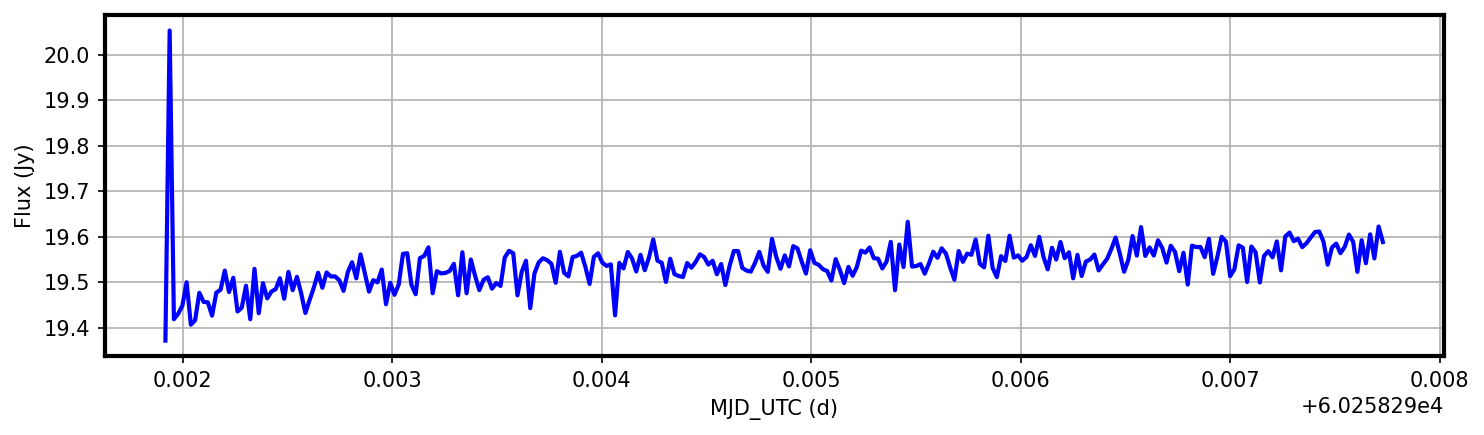

In [32]:
if do_viz:
    # Get Stage 3 white-light photometric light curve
    whtlt_file = os.path.join(tso3_dir, 'Stage3_whtlt.ecsv')
    data = ascii.read(whtlt_file, comment='#', delimiter=' ')
    mjd = data['MJD']
    wlc = data['whitelight_flux']

    # Make normal plots
    %matplotlib inline
    # Interactive plots
    #%matplotlib notebook

    # Plot light curve
    rc('axes', linewidth=2)
    fig, ax = plt.subplots(1, 1, figsize=(10, 3), dpi=150)
    ax.plot(mjd, wlc, 'b-', lw=2)
    plt.xlabel('MJD_UTC (d)')
    plt.ylabel('Flux (Jy)')
    plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join(tso3_dir, 'lrs_slitless_example_wlc.png'))

<hr style="border:1px solid gray"> </hr>

9.<font color='white'>-</font>Plot spectroscopic light curves<a class="anchor" id="plots-spec"></a>
------------------
Plot a subset of the spectroscopic light curves contained in the `*x1dints.fits` file. The fluxes are in units of Jy.<br>



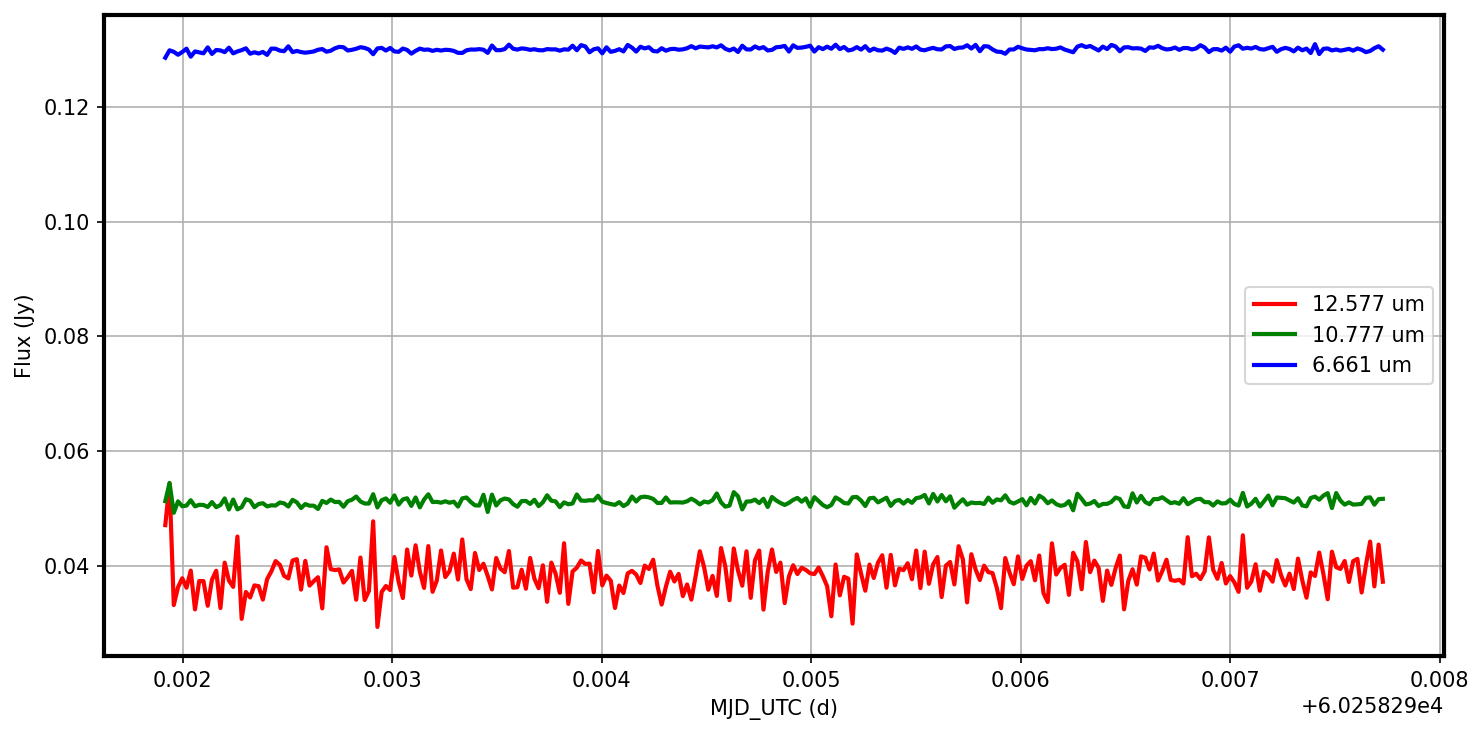

In [33]:
if do_viz:
    # Get x1dints files
    x1d_file = os.path.join(tso3_dir, 'Stage3_x1dints.fits')

    # Choose arbitrary wavelength elements to extract
    wave_idxs = [100, 200, 350]
    colors = ['r', 'g', 'b']

    # Read in file
    hdul = fits.open(x1d_file)
    int_times = hdul[1].data['int_mid_MJD_UTC']
    spec_tables = hdul[2:-1]
    wave = spec_tables[0].data['WAVELENGTH']

    # Plot light curves
    rc('axes', linewidth=2)
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=150)
    for ii in range(len(wave_idxs)):
        lc = np.array([spec_tables[k].data['FLUX'][wave_idxs[ii]] for k in range(len(int_times))])
        ax.plot(int_times, lc, colors[ii] + '-', lw=2, label="{:.3f} um".format(wave[wave_idxs[ii]]))
    plt.xlabel('MJD_UTC (d)')
    plt.ylabel('Flux (Jy)')
    plt.grid()
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig(os.path.join(tso3_dir, 'lrs_slitless_example_speclcs.png'))
    hdul.close()

<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src="https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_footer.png" alt="stsci_logo" width="200px"/> 